# This is the Exploratory Data Analysis for "To Bike or to not Bike".

Let's import the modules we will be using throughout the notebook. 

In [1]:
#to plot matplotlib inline
%matplotlib inline 
import matplotlib.pyplot as plt

from __future__ import division #perform divisions as performed in Python 3 while using 2.7

import numpy as np #for numpy arrays and simple math (correlation coeff and mean)
import scipy.stats as stats 
import seaborn as sns
sns.set(style="darkgrid")
import pandas as pd #to make use of dataframes...and more!

from datetime import datetime #to strip time 
from dateutil import tz #to change time zones. 

import scipy.stats as stats #for the linear regressor
import sklearn.linear_model as linear #for the linear regressor
import random #for the linear regressor
import patsy #for the linear regressor

## The weather (wx) data

To get the weather data we ran the notebook called "Project_EDA_wxDataReaderHourlyData". This notebook goes to the appropiate website, extracts and saves the hourly data for each day, and merges all the days into a single tsv file called wxData.tsv

The next cells will read in the file and put it in a dataframe:

In [2]:
path="./"
wxDataFile='wxData.tsv'
#read the weather data first
#---------------
#NOTE TO SELF: modified columns in tsv file:Now the first letter is lowercase and 
#no spaces between words.
#---------------
wx=pd.read_csv(path+wxDataFile,engine='c',sep='\t')

One thing we noticed is that weatherundeground.com logs the data in the UTC time zone. Let's make sure the dataframe KNOWS this (i.e. make the time time-zone aware). 

In [3]:
#data is read as UTC, then converted to eastern (EST)
wx.sort_values(['dateUtc'])
#get data w/o time zone
wxDateNoTimeZone = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in wx.dateUtc.values ]
#get data with UTC time-zome
wxDateInUtc = [ date.replace(tzinfo=tz.gettz('UTC')) for date in wxDateNoTimeZone]
#'transform' the data to EST time zone
wxDateInEst = [date.astimezone(tz.gettz('EST')) for date in wxDateInUtc]
#and put it in the data frame. 
wx["date"]=pd.DatetimeIndex(wxDateInEst)

At this point we have the weather data in dataframe WX. Let's get a quick look at the weather data:

In [4]:
wx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32649 entries, 0 to 32648
Data columns (total 16 columns):
conditions            32649 non-null object
dewPointF             32649 non-null float64
events                5370 non-null object
gustSpeedMPH          32649 non-null object
humidity              32646 non-null float64
precipitationIn       7204 non-null float64
seaLevelPressureIn    32649 non-null float64
temperatureF          32649 non-null float64
timeEDT               21132 non-null object
timeEST               11517 non-null object
visibilityMPH         32649 non-null float64
windDirection         32649 non-null object
windSpeedMPH          32649 non-null object
WindDirDegrees        32649 non-null int64
dateUtc               32649 non-null object
date                  32649 non-null datetime64[ns, tzfile('/usr/share/zoneinfo/EST')]
dtypes: datetime64[ns, tzfile('/usr/share/zoneinfo/EST')](1), float64(6), int64(1), object(8)
memory usage: 4.2+ MB


We'll come back to this later. Let's read in the Capital Bikeshare data (which, by the way, is a LOT). Due to long processing times we have decided to not use data from 2014. 

# The Capital Bikeshare data

The trip history data can be obtained from the DC (Capital) Bikeshare data website. `
(https://www.capitalbikeshare.com/trip-history-data). To get this data, we decided to download every quarter for years 2012, 2013, and 2014 (even though 2014 wasn't used). Then, the notebook "Project_EDA_BikeDataReader" is run to extract, parse, and save a file called "master.tsv", which is the combination of every quarter. 

Note that re-running this could take a while.

In [5]:
bikeDataFile='master.tsv'
#and now the bike data (it's huge)
bike=pd.read_csv(path+bikeDataFile,engine='c',sep='\t')

Let's ensure dates are datetime objects (this will facilitate data retrieval later):

In [6]:
#ensure dates datetime objects
bike["startDate"]=pd.to_datetime(bike["startDate"].values,utc=False)
bike["endDate"]=pd.to_datetime(bike["endDate"].values,utc=False)
#and that minutes are integers and not float
bike['durationMins']=bike['durationMins'].astype(int)

Let's quickly look at what we've got for bike data:

In [7]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7577197 entries, 0 to 7577196
Data columns (total 9 columns):
Unnamed: 0      int64
bikeNum         object
duration        object
endDate         datetime64[ns]
endStation      object
memberType      object
startDate       datetime64[ns]
startStation    object
durationMins    int64
dtypes: datetime64[ns](2), int64(2), object(5)
memory usage: 578.1+ MB


We know we will want to slice the data in certain ways (e.g. get data for February, 2012), so to facilitate this process let's get the indices to this "events" or areas of interest. 

In [8]:
#get indices for areas of interest 
#areas are really defined as combinations of years, month, day, or
#any other attribute. 

#indices to the years
bikeYear={}
tmp=bike.startDate.dt.year
bikeYear['2012']=tmp==2012
bikeYear['2013']=tmp==2013

#indices to the months
bikeMonth={}
tmp=bike.startDate.dt.month
bikeMonth['1']=tmp==1
bikeMonth['2']=tmp==2
bikeMonth['3']=tmp==3
bikeMonth['4']=tmp==4
bikeMonth['5']=tmp==5
bikeMonth['6']=tmp==6
bikeMonth['7']=tmp==7
bikeMonth['8']=tmp==8
bikeMonth['9']=tmp==9
bikeMonth['10']=tmp==10
bikeMonth['11']=tmp==11
bikeMonth['12']=tmp==12

#indices to the weekday (0=Monday, 6=Sunday)
bikeDay={}
tmp=bike.startDate.dt.weekday
bikeDay['M']=tmp==0
bikeDay['Tu']=tmp==1
bikeDay['W']=tmp==2
bikeDay['Th']=tmp==3
bikeDay['F']=tmp==4
bikeDay['Sa']=tmp==5
bikeDay['Su']=tmp==6

#Subscription Type
memType={}
memType['reg']= (bike.memberType=='Registered') | (bike.memberType=='Subscriber')
memType['cas']=bike.memberType=='Casual'

# just a dictionary we will need later on
dayNum2dayStr={0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun',7:'Sun'}

In [9]:
#check number of rentals each year
#an increment every year indicates that, when comparing data, we have to be careful if it's 
#not normalized somehow. 

#note that every rental occupies one line, so taking the length is sufficient to get 
#number of rentals. 

print "Year 2012:",len(bike[bikeYear['2012']])
print "Year 2013:",len(bike[bikeYear['2013']])

Year 2012: 2048316
Year 2013: 2583369


There was definitely an increase in ridership in 2013.
Note this is on a per-year basis. Let's look at ridership PER MONTH for every year:

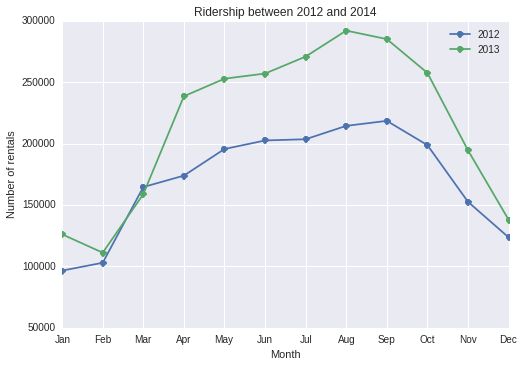

In [10]:
years=['2012','2013']
months=['1','2','3','4','5','6','7','8','9','10','11','12']
monthNames=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

#What was the number of rentals per month for years 2012-2014

for year in years:#
    data=[]
    for month in months: 
        data.append(len(bike[bikeYear[year] & bikeMonth[month]]))
    plt.plot(months,data,'-o')
plt.xlim(1,12)
plt.xticks(range(1,13),monthNames)
plt.xlabel('Month')
plt.ylabel('Number of rentals')
plt.title('Ridership in 2012 and 2013')
plt.legend(years)

The number of rentals, as seen in the plot above, increased from 2012 to 2013, especially during the non-winter months. Many factors can cause this number to increase, but one of then, the number of available bicycle stations, is known to us. Let's normalize it to the number of stations per month. The number of stations was verified at https://www.capitalbikeshare.com/system-data (Member Survey Reports)


In [11]:
#stations per month. 
numStations={}
for year in ['2012','2013']:
    for month in range(1,13):
        numStations[year+str(month)]=len(bike[bikeYear[year] & bikeMonth[str(month)]].startStation.unique())
        
print 'Stations in 2012:',len(bike[bikeYear['2012']].startStation.unique())
print 'Stations in 2013:',len(bike[bikeYear['2013']].startStation.unique())

Stations in 2012: 200
Stations in 2013: 320


Of course ridership increased in 2013, there were more bike stations available!

Let's normalize the ridership:

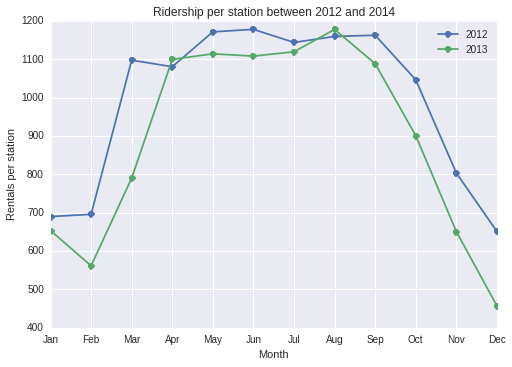

In [12]:
#What was the number of rentals per month per station for years 2012-2013

for year in ['2012','2013']:
    data=[]
    for month in months: 
        data.append(len(bike[bikeYear[year] & bikeMonth[month]])/numStations[year+month])
        
    plt.plot(months,data,'-o')
plt.xlim(1,12)
plt.xticks(range(1,13),monthNames)
plt.xlabel('Month')
plt.ylabel('Rentals per station')
plt.title('Ridership per station between 2012 and 2014')
plt.legend(years)
plt.show()

A couple of things can be seen in this plot. Let's go over them one by one:
* Ridership is indeed lower during the winter months and peaks out during Aug-Sept (the warmer months). Could this be an indication that there is a relationship between air temperature and ridership? We'll see later on. 
* Although there was an increase in the number of stations in 2013, the ridership per station was about the same or slightly lower, depending on the month. 

Let's look at the registered vs. casual users ridership in 2012. Note that registered users are defined as customers that hold a yearly or montly subscription, whereas casuals are considered 1,2, or 5-day subscriptions:

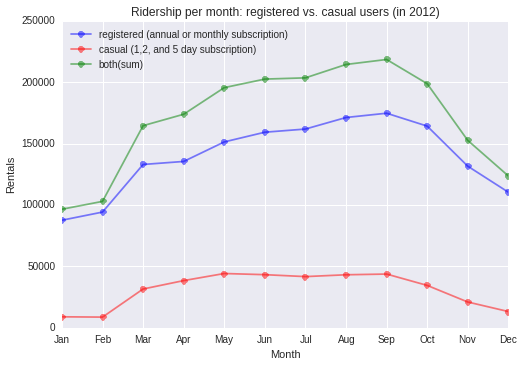

In [13]:
data={}

fig, ax1 = plt.subplots()
years=['2012']
linspec=['-ob','-or','-og','--db','--dr','--dg']
for i,year in enumerate(years):
    data['reg']=[]
    data['cas']=[]
    data['both']=[]
    year=years[i]
    for month in months:
        data['reg'].append(len(bike[bikeYear[year] & bikeMonth[month] & memType['reg']]))
        data['cas'].append(len(bike[bikeYear[year] & bikeMonth[month] & memType['cas']]))
        data['both'].append(len(bike[bikeYear[year] & bikeMonth[month]]))

    ax1.plot(months,data['reg'],linspec[3*i],alpha=0.5)
    ax1.plot(months,data['cas'],linspec[3*i+1],alpha=0.5)
    ax1.plot(months,data['both'],linspec[3*i+2],alpha=0.5)
ax1.legend(['registered (annual or monthly subscription)','casual (1,2, and 5 day subscription)',\
            'both(sum)'],loc=2)
ax1.set_xlim(1,12)
ax1.set_xticks(range(1,13))
ax1.set_xticklabels(monthNames)
ax1.set_xlabel('Month')
ax1.set_ylabel('Rentals')
ax1.set_title('Ridership per month: registered vs. casual users (in '+ year+')')

Nothing too interesting here:

We expected the casual users to ride less than registered ones (hello....if you paid for it, why would you not use it?!), and that has been confirmed. 

Let's look at year 2013 and see if there are any similarities. Remember, the motiviation here is to see if there is any drastic behavior between the users, a behavior that could affect what we are trying to model. Also, note that if rain gets you wet (it does in this world, perhaps not in the world of JHU's David Kaplan), regardless of whether you are a registered or casual users, you will most likely not ride in the rain. What do we mean by that? The behavior of these two user types in this regard should be very similar, if not the same. But hey, there may be outliers: users that want to make the best of their subscription, even it it means paying a little extra to not get wet. 

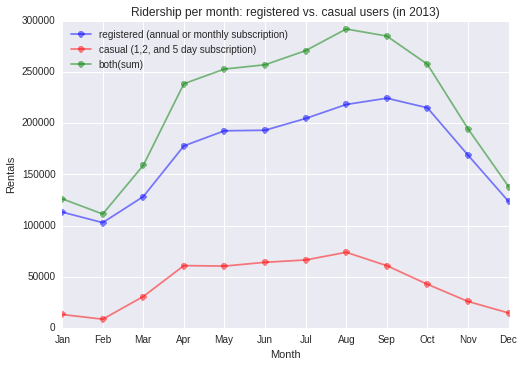

In [14]:
data={}

fig, ax1 = plt.subplots()
years=['2013']
linspec=['-ob','-or','-og','--db','--dr','--dg']
for i,year in enumerate(years):
    data['reg']=[]
    data['cas']=[]
    data['both']=[]
    year=years[i]
    for month in months:
        data['reg'].append(len(bike[bikeYear[year] & bikeMonth[month] & memType['reg']]))
        data['cas'].append(len(bike[bikeYear[year] & bikeMonth[month] & memType['cas']]))
        data['both'].append(len(bike[bikeYear[year] & bikeMonth[month]]))

    ax1.plot(months,data['reg'],linspec[3*i],alpha=0.5)
    ax1.plot(months,data['cas'],linspec[3*i+1],alpha=0.5)
    ax1.plot(months,data['both'],linspec[3*i+2],alpha=0.5)
ax1.legend(['registered (annual or monthly subscription)','casual (1,2, and 5 day subscription)',\
            'both(sum)'],loc=2)
ax1.set_xlim(1,12)
ax1.set_xticks(range(1,13))
ax1.set_xticklabels(monthNames)
ax1.set_xlabel('Month')
ax1.set_ylabel('Rentals')
ax1.set_title('Ridership per month: registered vs. casual users (in '+ year+')')

The behavior (ridership) is very similar as in year 2012.

# How does temperature correlate with Ridership?

To do this we'll need to define similar events (or areas of interest)  for both the weather and bike data. This way we can properly and easily slice the dataframes. Let's start with the weather data: 

In [15]:
#more areas of interest, but now related to weather

#indices to the years
wxYear={}
tmp=wx.date.dt.year
wxYear['2012']=tmp==2012
wxYear['2013']=tmp==2013

#indices to the months
wxMonth={}
tmp=wx.date.dt.month
wxMonth['1']=tmp==1
wxMonth['2']=tmp==2
wxMonth['3']=tmp==3
wxMonth['4']=tmp==4
wxMonth['5']=tmp==5
wxMonth['6']=tmp==6
wxMonth['7']=tmp==7
wxMonth['8']=tmp==8
wxMonth['9']=tmp==9
wxMonth['10']=tmp==10
wxMonth['11']=tmp==11
wxMonth['12']=tmp==12

#indices to the weekday (0=Monday, 6=Sunday)
wxDay={}
tmp=wx.date.dt.dayofweek
wxDay['M']=tmp==0
wxDay['Tu']=tmp==1
wxDay['W']=tmp==2
wxDay['Th']=tmp==3
wxDay['F']=tmp==4
wxDay['Sa']=tmp==5
wxDay['Su']=tmp==6

Let's look at year 2012. We will plot the mean temperature for each month vs. the ridership. Why mean and not median, you could ask. We want the metric for temperature to be influenced by drastic changes in temperature BECAUSE we think it precisely affects ridership and we want to see that relationship.

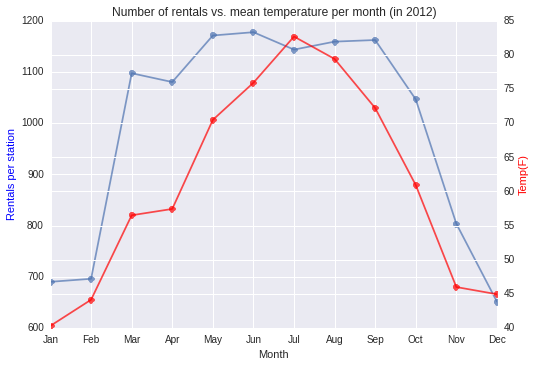

In [16]:
data={}
data['bike']=[]
data['wx']=[]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
year='2012'
for month in months:
    
    data['bike'].append(len(bike[bikeYear[year] & bikeMonth[month]]) \
                       / numStations[year+month])
    data['wx'].append(np.mean(wx.temperatureF[wxYear[year] & wxMonth[month]]))

ax1.plot(months,data['bike'],'-o',alpha=0.7)
ax2.plot(months,data['wx'],'-or',alpha=0.7)
ax1.set_xlim(1,12)
ax1.set_xticks(range(1,13))
ax1.set_xticklabels(monthNames)
ax1.set_xlabel('Month')
ax1.set_ylabel('Rentals per station',color='b')
ax1.set_title('Number of rentals vs. mean temperature per month (in '+ year+')')

ax2.set_ylabel('Temp(F)',color='r')

There is definitely a positive correlation between number of rentals and the mean temperature for each month. Now, with a little bit of domain knowledge (we all know a bit about weather, right?) we can say that had we had data for duration of daylight, it would have positively correlated with it as well. That is, during the winter months the duration of daylight is at its lowest, pretty much as in the ridership curve.

Let's quickly compute the correlation coefficient between these two "signals":

In [17]:
np.corrcoef(data['bike'],data['wx'])[0,1]

0.89611929969791082

The correlation coefficient is ~0.90. HOWEVER, note that this is aggregate data. Let's improve this plot a bit: we could also do this for each week of the year and have 365/7=~52 data points instead of just 12:

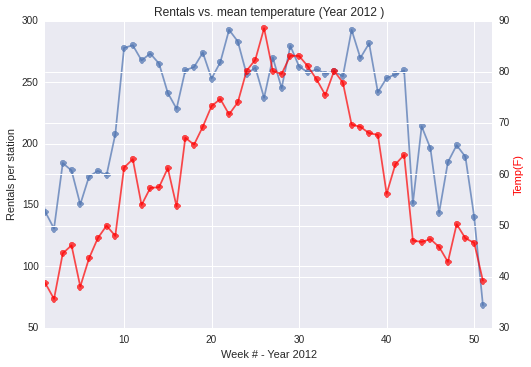

In [18]:
data={}
data['bike']=[]
data['wx']=[]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
year='2012'
#Get subset of dataframe (speeds up comparisons)
weeks=sorted(bike.startDate.dt.weekofyear.unique())
bikeSubset=bike[bikeYear[year]]
wxSubset=wx[wxYear[year]]

for week in weeks:
    #get number of stations in this week using num stations in the month (approximate)
    theMonth=int(np.ceil(week/4.34))
    sel= bikeSubset.startDate.dt.weekofyear==week
    data['bike'].append(len(bikeSubset[sel]) / numStations[year+str(theMonth)])
    sel= wxSubset.date.dt.weekofyear==week
    data['wx'].append(np.mean(wxSubset.temperatureF[sel]))

ax1.plot(data['bike'],'-o',alpha=0.7)
ax2.plot(data['wx'],'-or',alpha=0.7)
ax1.set_xlim(1,max(weeks))
ax1.set_xlabel('Week # - Year '+year)
ax1.set_ylabel('Rentals per station')
ax1.set_title('Rentals vs. mean temperature (Year '+year+' )')

ax2.set_ylabel('Temp(F)',color='r')

A-ha! Much better. Let's quickly compute the correlation coefficient:

In [19]:
np.corrcoef(data['bike'],data['wx'])[0,1]

0.79317168147571382

Even with more granularity in the data, we can see that they still are positively correlated. In other words, when the mean temperature increases, so will the ridership, and when the mean temperature decreases, so will the ridership. Ridership "follows" the temperature. 

Now, let's not get too distracted and recall our motivation: we wanted to see how weather affects ridership, and yes, weather meant temperature, but it also means rain and snow. Let's not forget this as it MAY be an important factor. This second factor is most apparrent on a per hour basis. In other words, if it rains at 5 am, it may not affect riders in the afternoon, and thus, the ridership for that month may have not changed much. 

All this means is that we have to find a way to see the data on a per hour basis. We have to be very careful because it is difficult to show all this data for three years. And in fact, it may not be smart or fruitful to do that. We will see...but for now we can say that we have enough information to build model (#rentals ~ temperature + error). However, we are still doing exploration, so let's defer those details until after we have more information. OK? OK. 

Before plotting a histogram using the hours, we must mention that the data source for the bike data did not say the time zone this data was logged in. We will have to look at the histograms and make a choice that makes sense. That is, we expect very few riders during the early hours of the morning and in the late hours of a day. To do this, we'll pick a month (August) and a year (2012):

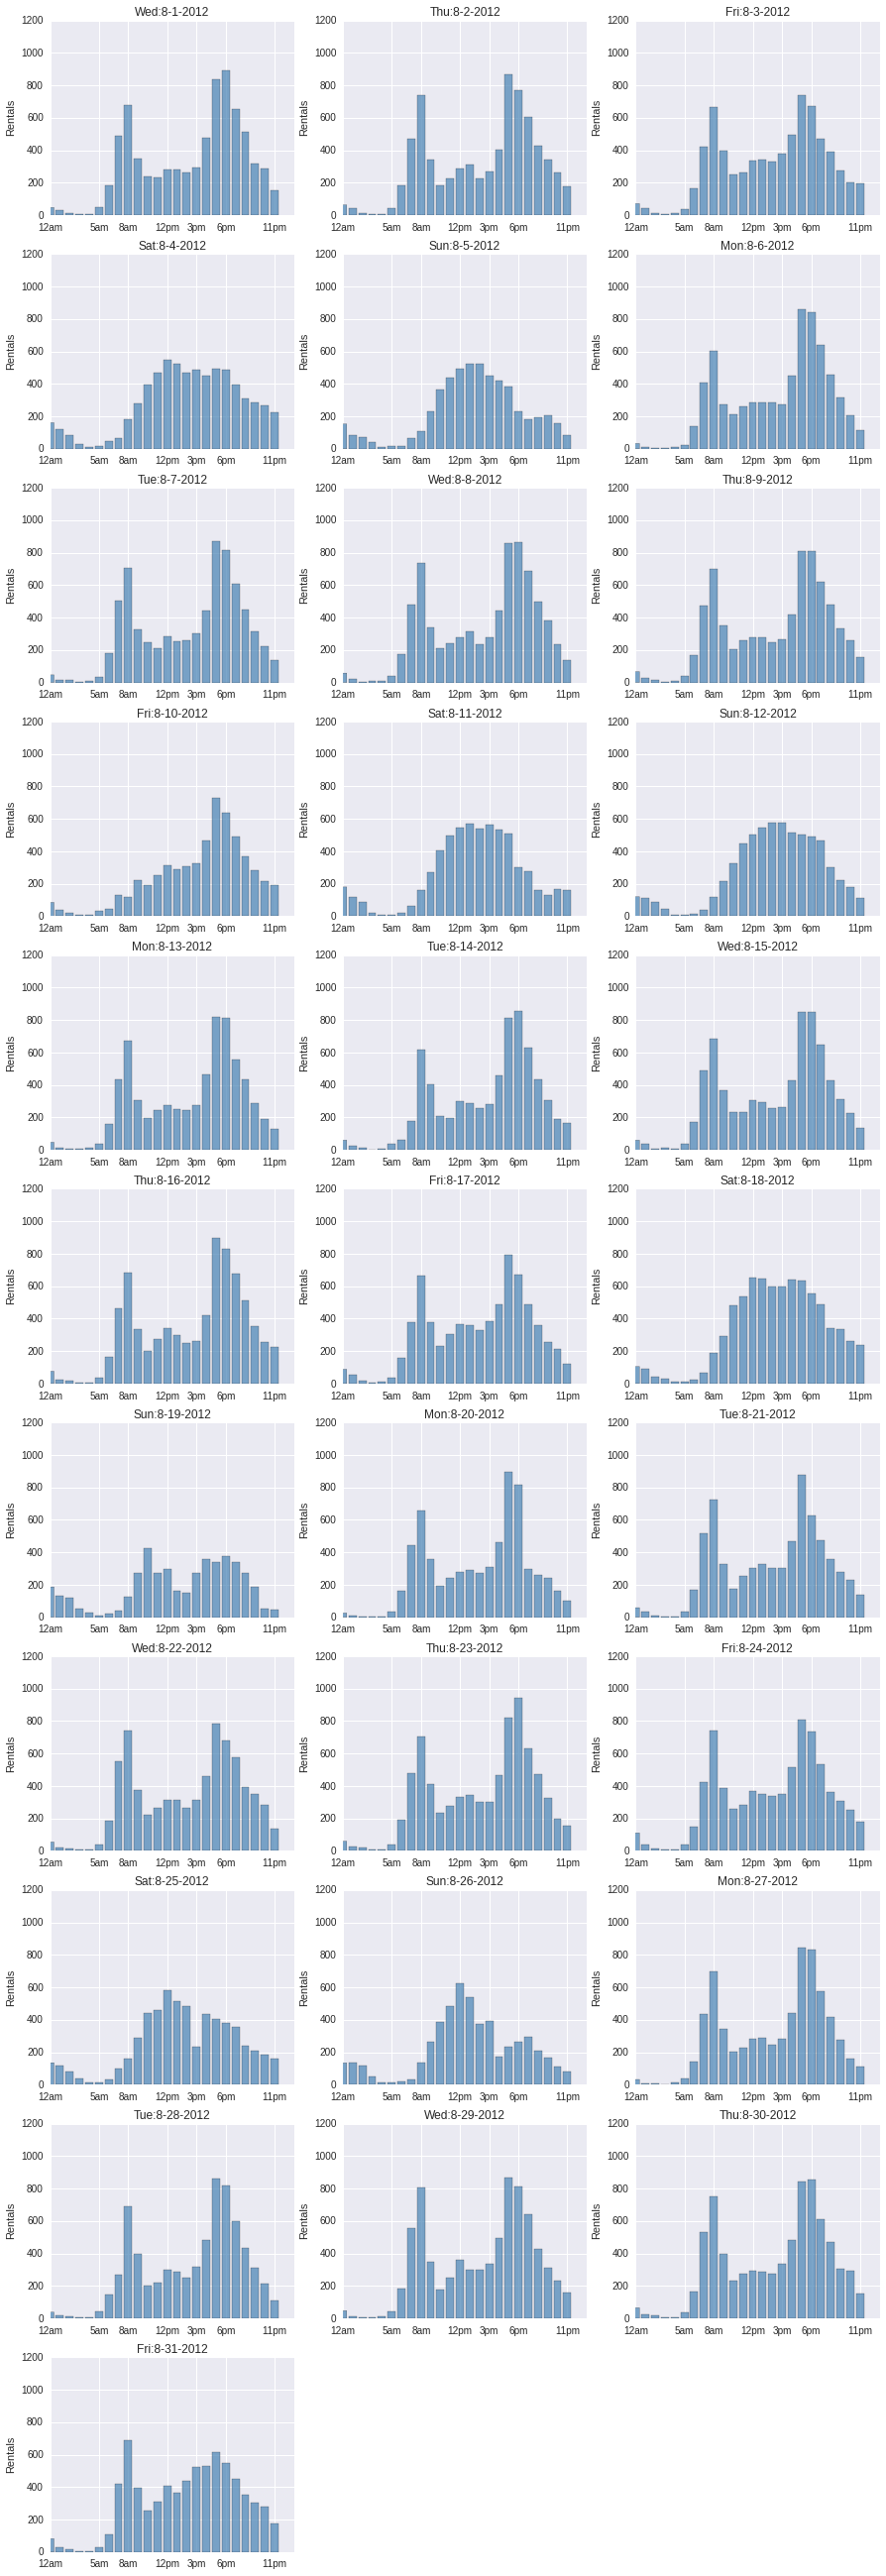

In [20]:
#let's look at how riders behave during a low ridership month,
#although what we really want to know is if time is in UTC or
#or local time

figure = plt.figure(figsize=(15,50))
data=pd.DataFrame()
year='2012'
month='8'

for day in range(1,31+1):
    bikeData=bike[bikeYear[year] & bikeMonth[month] & (bike.startDate.dt.day==day)]
    wxData=wx[wxYear[year] & wxMonth[month] & (wx.date.dt.day==day)]
    if len(bikeData)>0: #some months have less than 31 days and make this 0
        ax1 = figure.add_subplot(12, 3, day)
        ax1.hist(bikeData.startDate.dt.hour.values,alpha=0.7,color='steelblue',bins=np.arange(25)-0.5,rwidth=0.8)

        ax1.set_title(datetime.strptime(year+' '+month+' '+str(day),'%Y %m %d').strftime('%a')+\
                       ':'+month+'-'+str(day)+'-'+year)
        ax1.set_ylim(0,1200)
        ax1.set_xlim(0,25)
        ax1.set_ylabel('Rentals')
        ax1.set_xticks([0,5,8,12,15,18,23])
        ax1.set_xticklabels(['12am','5am','8am','12pm','3pm','6pm','11pm'])

plt.show()

It can be seen that time is in local time.

The histograms above were for a high-ridership month. Let's do a low one (Feb 2012)'

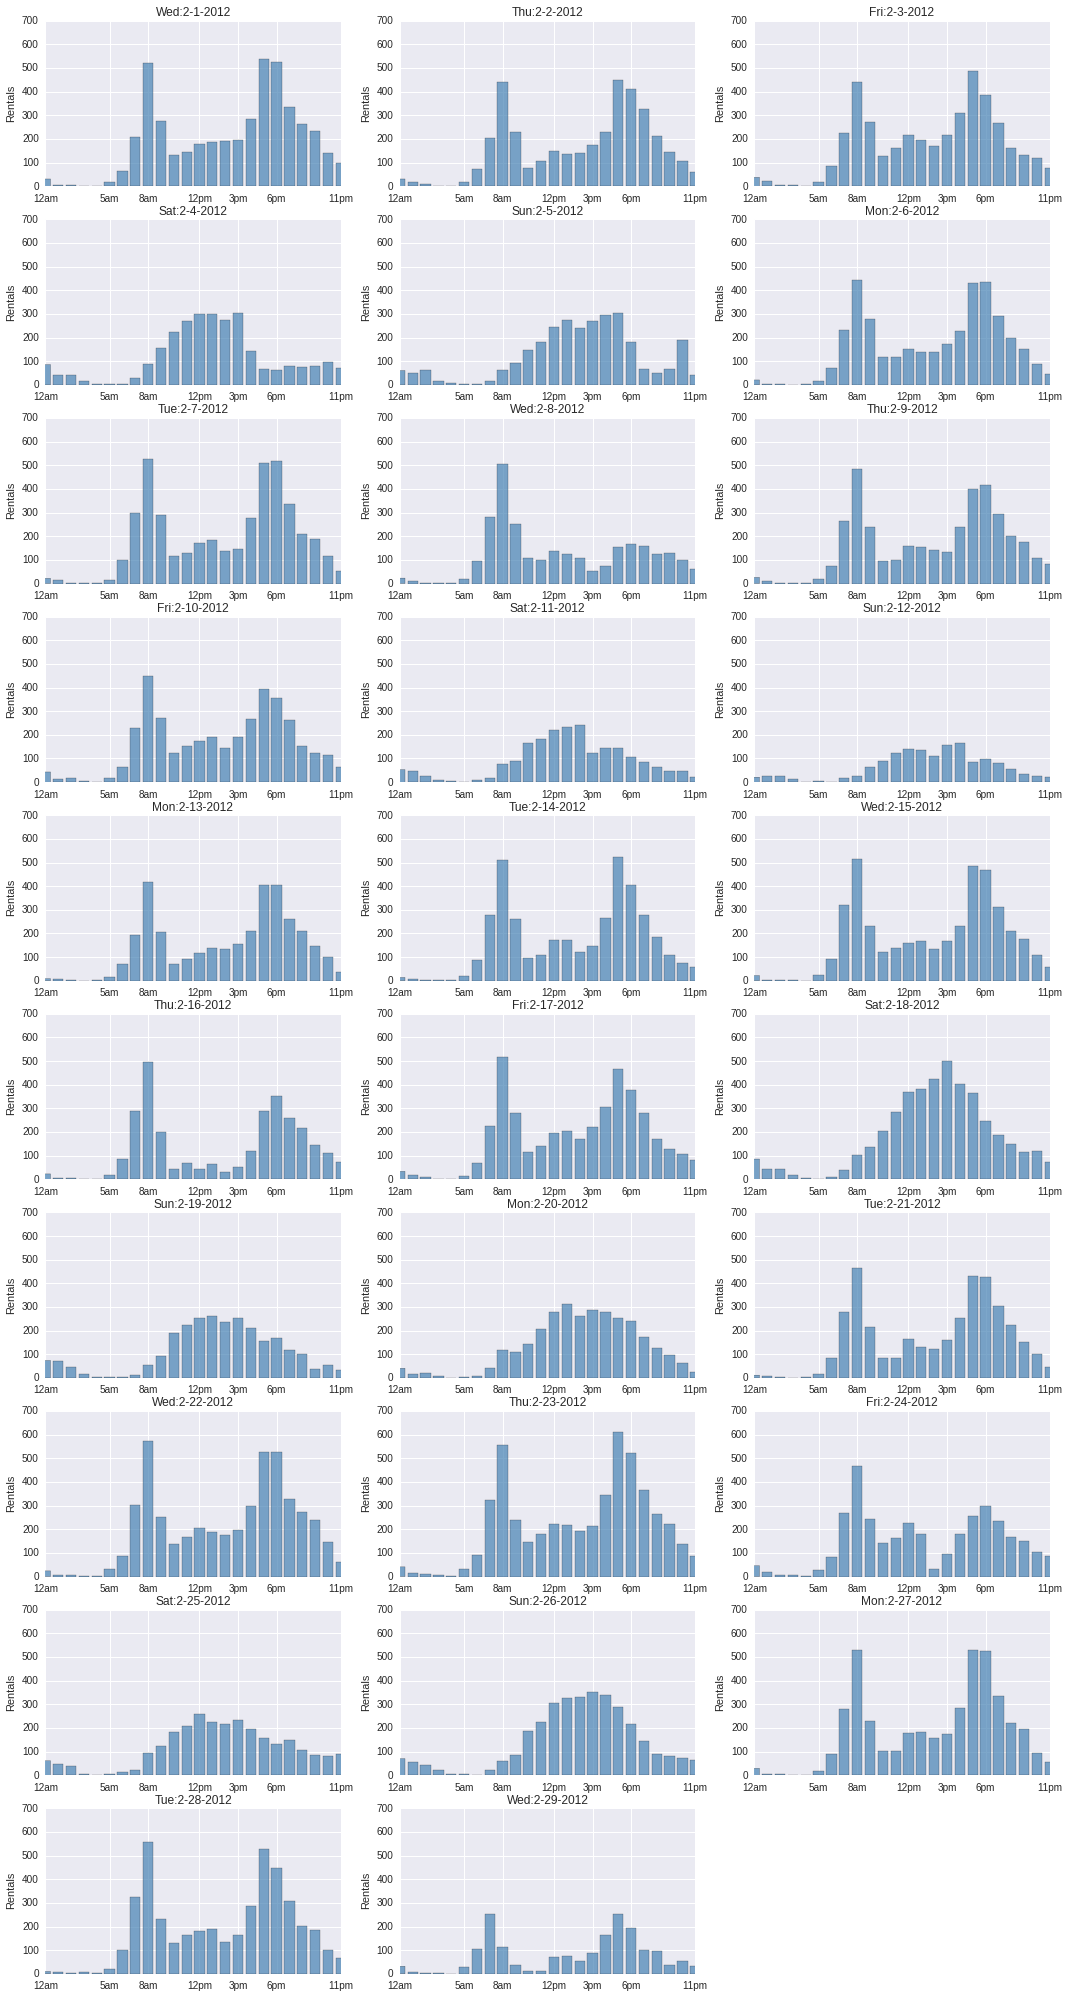

In [21]:
#let's look at how riders behave during a low ridership month,
#although what we really want to know is if time is in UTC or
#or local time

figure = plt.figure(figsize=(18,35))
data=pd.DataFrame()
year='2012'
month='2'

for day in range(1,31+1):
    bikeData=bike[bikeYear[year] & bikeMonth[month] & (bike.startDate.dt.day==day)]
    wxData=wx[wxYear[year] & wxMonth[month] & (wx.date.dt.day==day)]
    if len(bikeData)>0: #some months have less than 31 days and make this 0
        ax1 = figure.add_subplot(10, 3, day)
        ax1.hist(bikeData.startDate.dt.hour.values,alpha=0.7,color='steelblue',bins=np.arange(25)-0.5,rwidth=0.8)
        ax1.set_title(datetime.strptime(year+' '+month+' '+str(day),'%Y %m %d').strftime('%a')+\
                       ':'+month+'-'+str(day)+'-'+year)
        ax1.set_ylim(0,700)
        ax1.set_xlim(0,23)
        ax1.set_ylabel('Rentals')
                     
        ax1.set_xticks([0,5,8,12,15,18,23])
        ax1.set_xticklabels(['12am','5am','8am','12pm','3pm','6pm','11pm'])
        
plt.show()

Very, very interesting. We see a couple of patterns here:

Ridership behavior in terms of volume IS different when one compares August and February. Nonetheless, how it is DISTRIBUTED -when compared to the same day- does not change much. 

Ridership is quite different during the weekends compared to weekdays.During weekends, it seems to be normally distributed with mean around 1300 (or 1pm). During weekedays, it looks like a mixture distribution where the first one may be normally distributed with mean around 8am, and the second around 5pm. The variance of the first distribution seems to be smaller than the second one. 

How does one interpret this? 

Well, in light of our domain knowledge, it tells us that during weekdays people tend to use the bikes as a mode of transportation to get to their job locations (note it coincides with the typical 8-5pm work hours). On the other hand, during the weekends, most people (in my world, that is) wake up at 10am and decide to bike at around 12. 

Also, these two months confirm that the time is in the local time zome and not in UTC.

Now, it's a bit painful to have to scroll down a few times to be able to compare a Monday with a Monday, a Saturday with another Saturday, etc...

Let's do the same plot but after grouping them by day:

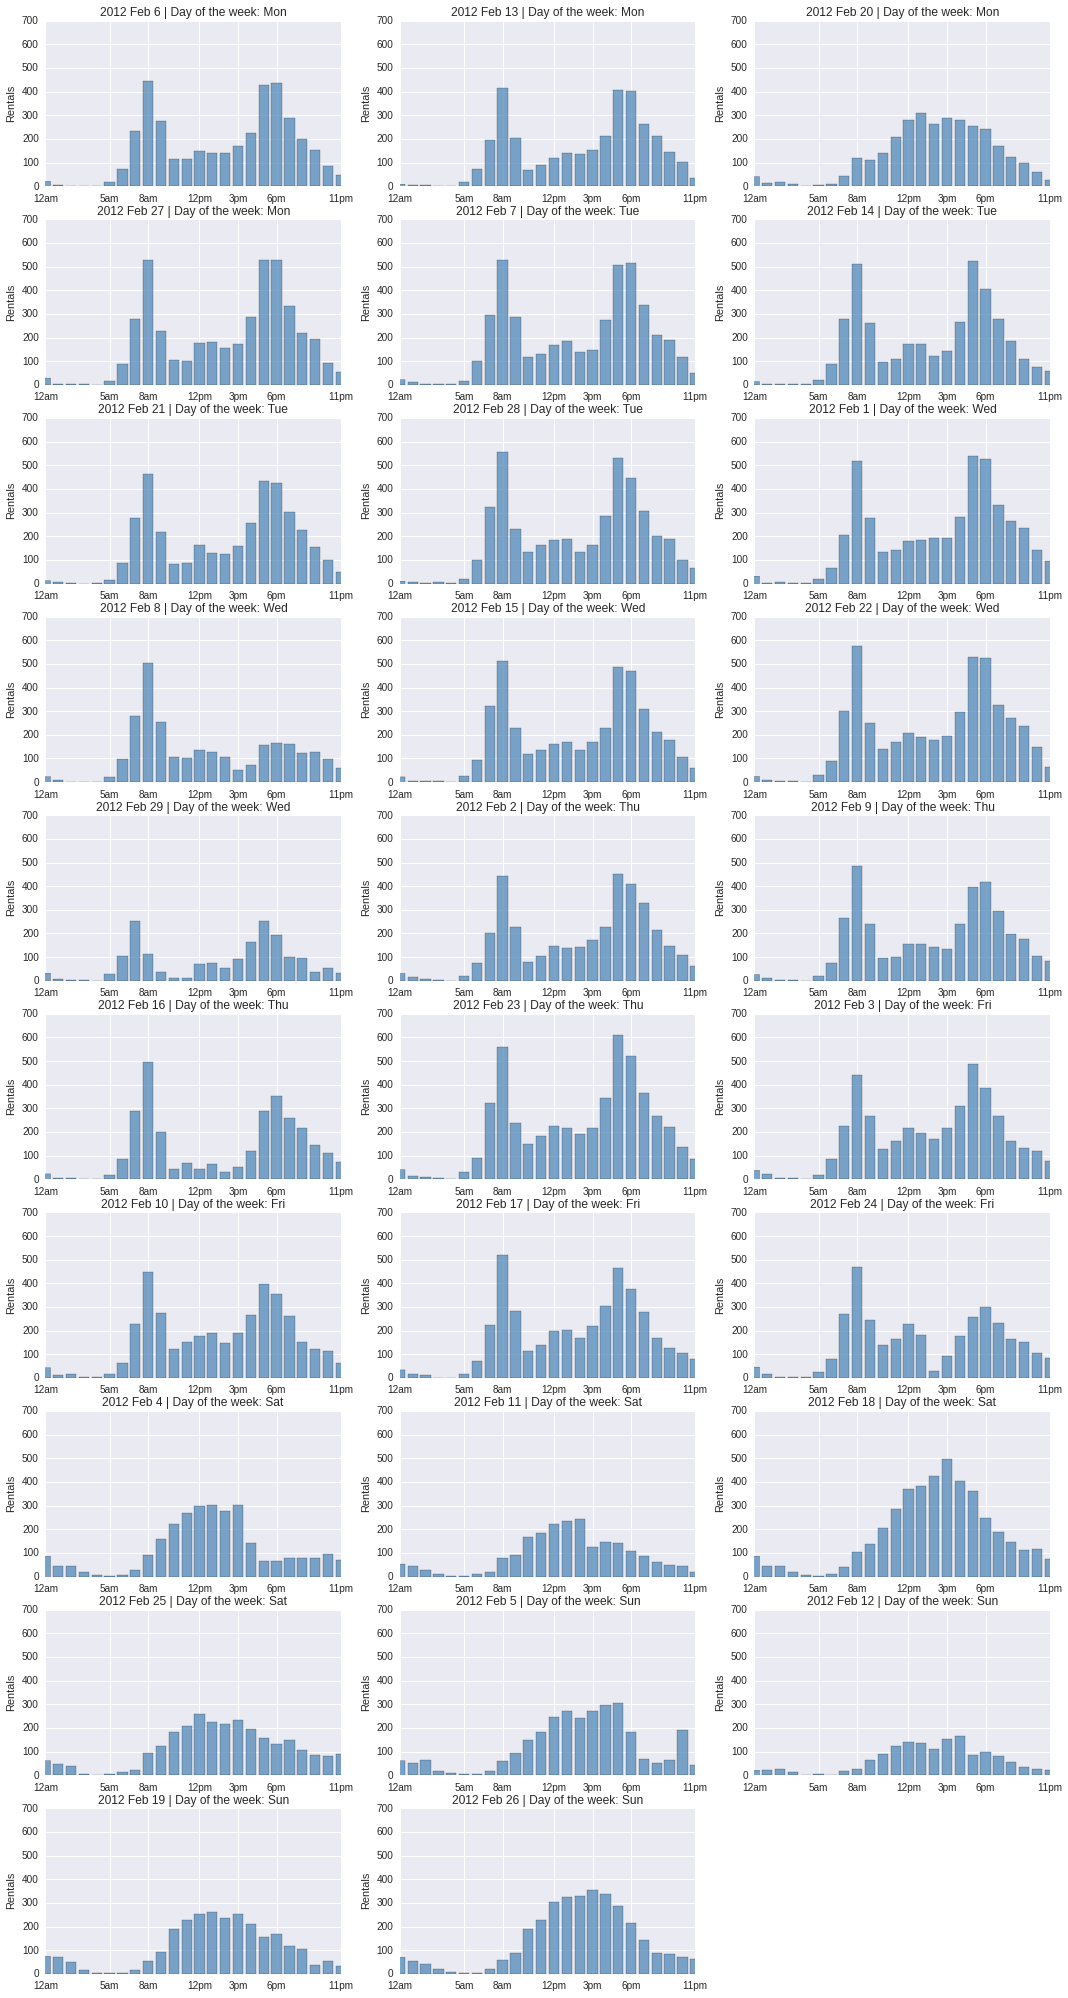

In [22]:
figure = plt.figure(figsize=(18,35))
year='2012'
month='2'

#get weeks relative to the year
bikeData=bike[bikeYear[year] & bikeMonth[month]]
wxData=wx[wxYear[year] & wxMonth[month]]
weeksOfYear=bikeData.startDate.dt.week.unique()

i=1
#now, find day=0 for each week, then day=1 for each week
for weekDay in range(0,7+1):
    bikeDataForADay=bikeData[bikeData.startDate.dt.weekday==weekDay]
    wxDataForADay=wxData[wxData.date.dt.weekday==weekDay]
    for week in weeksOfYear:
        bikeDataForThisDayInThisWeek=bikeDataForADay[bikeDataForADay.startDate.dt.week==week]
        wxDataForThisDayInThisWeek=wxDataForADay[wxDataForADay.date.dt.week==week]
        if len(bikeDataForThisDayInThisWeek)>0:
            ax1 = figure.add_subplot(10, 3, i)

            ax1.hist(bikeDataForThisDayInThisWeek.startDate.dt.hour.values,alpha=0.7,color='steelblue',bins=np.arange(25)-0.5,rwidth=0.8)
                   
            ax1.set_title(year+' '+monthNames[int(month)-1]+ ' '+\
                           str(min(bikeDataForThisDayInThisWeek.startDate.dt.day)) +' | Day of the week: '+dayNum2dayStr[weekDay])
            ax1.set_ylim(0,700)
            ax1.set_xlim(0,23)
            ax1.set_ylabel('Rentals')
            ax1.set_xticks([0,5,8,12,15,18,23])
            ax1.set_xticklabels(['12am','5am','8am','12pm','3pm','6pm','11pm'])
            
            i+=1
plt.show()

Now we are talking! This plot is really informative. For example, look at the Wednesdays for this month/year. 
Can you spot anything out of ordinary?

YES! Let's replot just the Weds to highlight it:

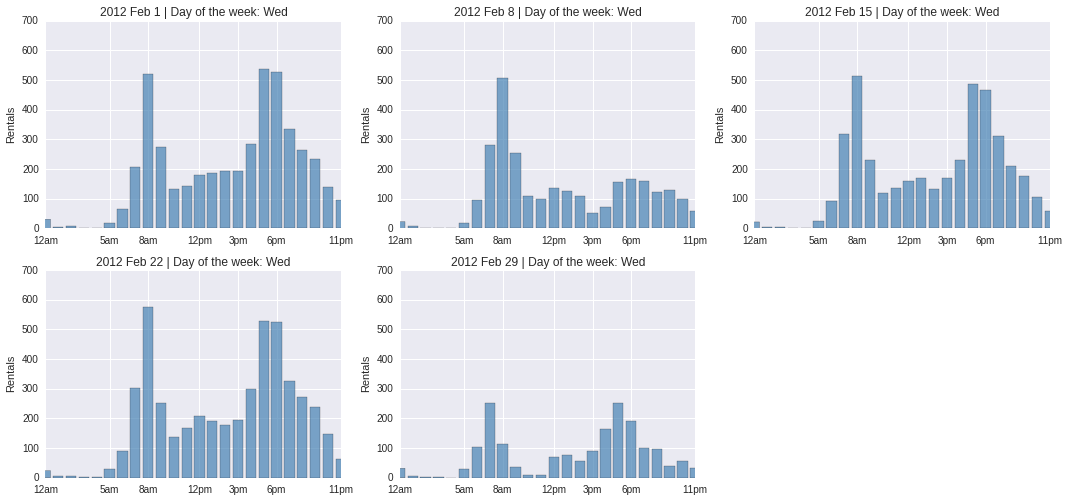

In [23]:
figure = plt.figure(figsize=(18,35))
year='2012'
month='2'

#get weeks relative to the year
bikeData=bike[bikeYear[year] & bikeMonth[month]]
wxData=wx[wxYear[year] & wxMonth[month]]
weeksOfYear=bikeData.startDate.dt.week.unique()

i=1
#now, find day=0 for each week, then day=1 for each week
#for weekDay in range(0,7+1):
for weekDay in [2]: #Wednesday is 2
    bikeDataForADay=bikeData[bikeData.startDate.dt.weekday==weekDay]
    wxDataForADay=wxData[wxData.date.dt.weekday==weekDay]
    for week in weeksOfYear:
        bikeDataForThisDayInThisWeek=bikeDataForADay[bikeDataForADay.startDate.dt.week==week]
        wxDataForThisDayInThisWeek=wxDataForADay[wxDataForADay.date.dt.week==week]
        if len(bikeDataForThisDayInThisWeek)>0:
            ax1 = figure.add_subplot(8, 3, i)


            ax1.hist(bikeDataForThisDayInThisWeek.startDate.dt.hour.values,alpha=0.7,color='steelblue',bins=np.arange(25)-0.5,rwidth=0.8)
                   
            ax1.set_title(year+' '+monthNames[int(month)-1]+ ' '+\
                           str(min(bikeDataForThisDayInThisWeek.startDate.dt.day)) +' | Day of the week: '+dayNum2dayStr[weekDay])
            ax1.set_ylim(0,700)
            ax1.set_xlim(0,23)
            ax1.set_ylabel('Rentals')
            ax1.set_xticks([0,5,8,12,15,18,23])
            ax1.set_xticklabels(['12am','5am','8am','12pm','3pm','6pm','11pm'])
            i+=1
plt.show()

Notice how the SECOND and LAST Wednesday of February 2012 are different. What happened here?! Why is the pattern different? Could it have been the weather? 

That's what we think...let's dig in.

To do this we have to figure out a way of overlaying weather conditions on a per-hour basis. 

With that in mind, let's talk about the rain and the snow. In the weather dataframe there is a column that tells us the weather "conditions". Let's look at the possible values:

In [24]:
wx.conditions.unique()

array(['Overcast', 'Light Snow', 'Mostly Cloudy', 'Scattered Clouds',
       'Partly Cloudy', 'Clear', 'Thunderstorm', 'Light Rain',
       'Light Drizzle', 'Rain', 'Heavy Rain', 'Fog', 'Patches of Fog',
       'Haze', 'Heavy Thunderstorms and Rain', 'Thunderstorms and Rain',
       'Light Thunderstorms and Rain', 'Mist', 'Shallow Fog', 'Snow',
       'Light Ice Pellets', 'Light Freezing Rain', 'Unknown',
       'Light Freezing Drizzle', 'Heavy Snow', 'Blowing Snow',
       'Ice Pellets'], dtype=object)

As it can be seen, that is a LOT. Nonetheless, with some domain knowledge (because we all have ridden a bike, right?) we know that riding while it is snowing isn't cool, much less safe, nor it is riding under the rain. So, what if we could ENCODE the weather conditions according to their severity to bike riders? For example, "FOG" should not discourage a rider from riding the cool red bike as much as, say,  "RAIN". 

To assess the severity of the weather condition, we will resort to common sense. Now, in the unique values list above, we noticed value "unknown". Let's check how often that occurs (because if it occurs too often then the data could be unusable for our purposes):

In [25]:
print 'Unknown found', sum(wx.conditions=='Unknown'), 'times'
print 'this corresponds to',100*sum(wx.conditions=='Unknown')/len(wx),'% of the samples in the weather data'

Unknown found 16 times
this corresponds to 0.0490060951331 % of the samples in the weather data


That is a very small percentage of samples. It's a non-issue. 
Let's perform the encoding (where low severity is 0, and high severity is 2)

In [26]:
#let's order them in what we think is least to most dangerous for bikers
wxEventDict={}

wxEventDict['Unknown']=0
wxEventDict['Clear']=0
wxEventDict['Shallow Fog']=0
wxEventDict['Scattered Clouds']=0
wxEventDict['Partly Cloudy']=0
wxEventDict['Mostly Cloudy']=0
wxEventDict['Overcast']=0
wxEventDict['Haze']=0
wxEventDict['Patches of Fog']=0
wxEventDict['Fog']=0

wxEventDict['Light Snow']=1
wxEventDict['Mist']=1
wxEventDict['Light Drizzle']=1
wxEventDict['Light Rain']=1
wxEventDict['Blowing Snow']=1
wxEventDict['Thunderstorm']=1

wxEventDict['Light Thunderstorms and Rain']=2
wxEventDict['Rain']=2
wxEventDict['Thunderstorms and Rain']=2
wxEventDict['Snow']=2
wxEventDict['Heavy Thunderstorms and Rain']=2
wxEventDict['Heavy Snow']=2
wxEventDict['Light Ice Pellets']=2
wxEventDict['Light Freezing Drizzle']=2
wxEventDict['Ice Pellets']=2
wxEventDict['Light Freezing Rain']=2
wxEventDict['Heavy Rain']=2

In terms of all weather events, let's look how they are distributed:

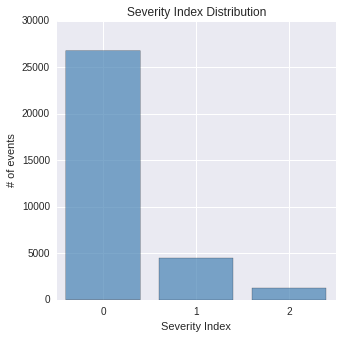

In [27]:
events=[wxEventDict[wxEvent] for wxEvent in wx.conditions]
figure = plt.figure(figsize=(5,5))
plt.hist(events,alpha=0.7,color='steelblue',bins=np.arange(4)-0.5,rwidth=0.8)
plt.xticks([0,1,2])
plt.yticks()
plt.xlim(-0.5,2.5)
plt.xlabel('Severity Index')
plt.title('Severity Index Distribution')
plt.ylabel('# of events')

The histogram above does not really tell us a lot, but at least we now know that most of the time it should be OK for riders to ride (of course, base on our severity scale). 

Let's now plot February 2012 ridership per hour WITH the weather severity index (we came up with this term for this analysis) overlaid on top: 

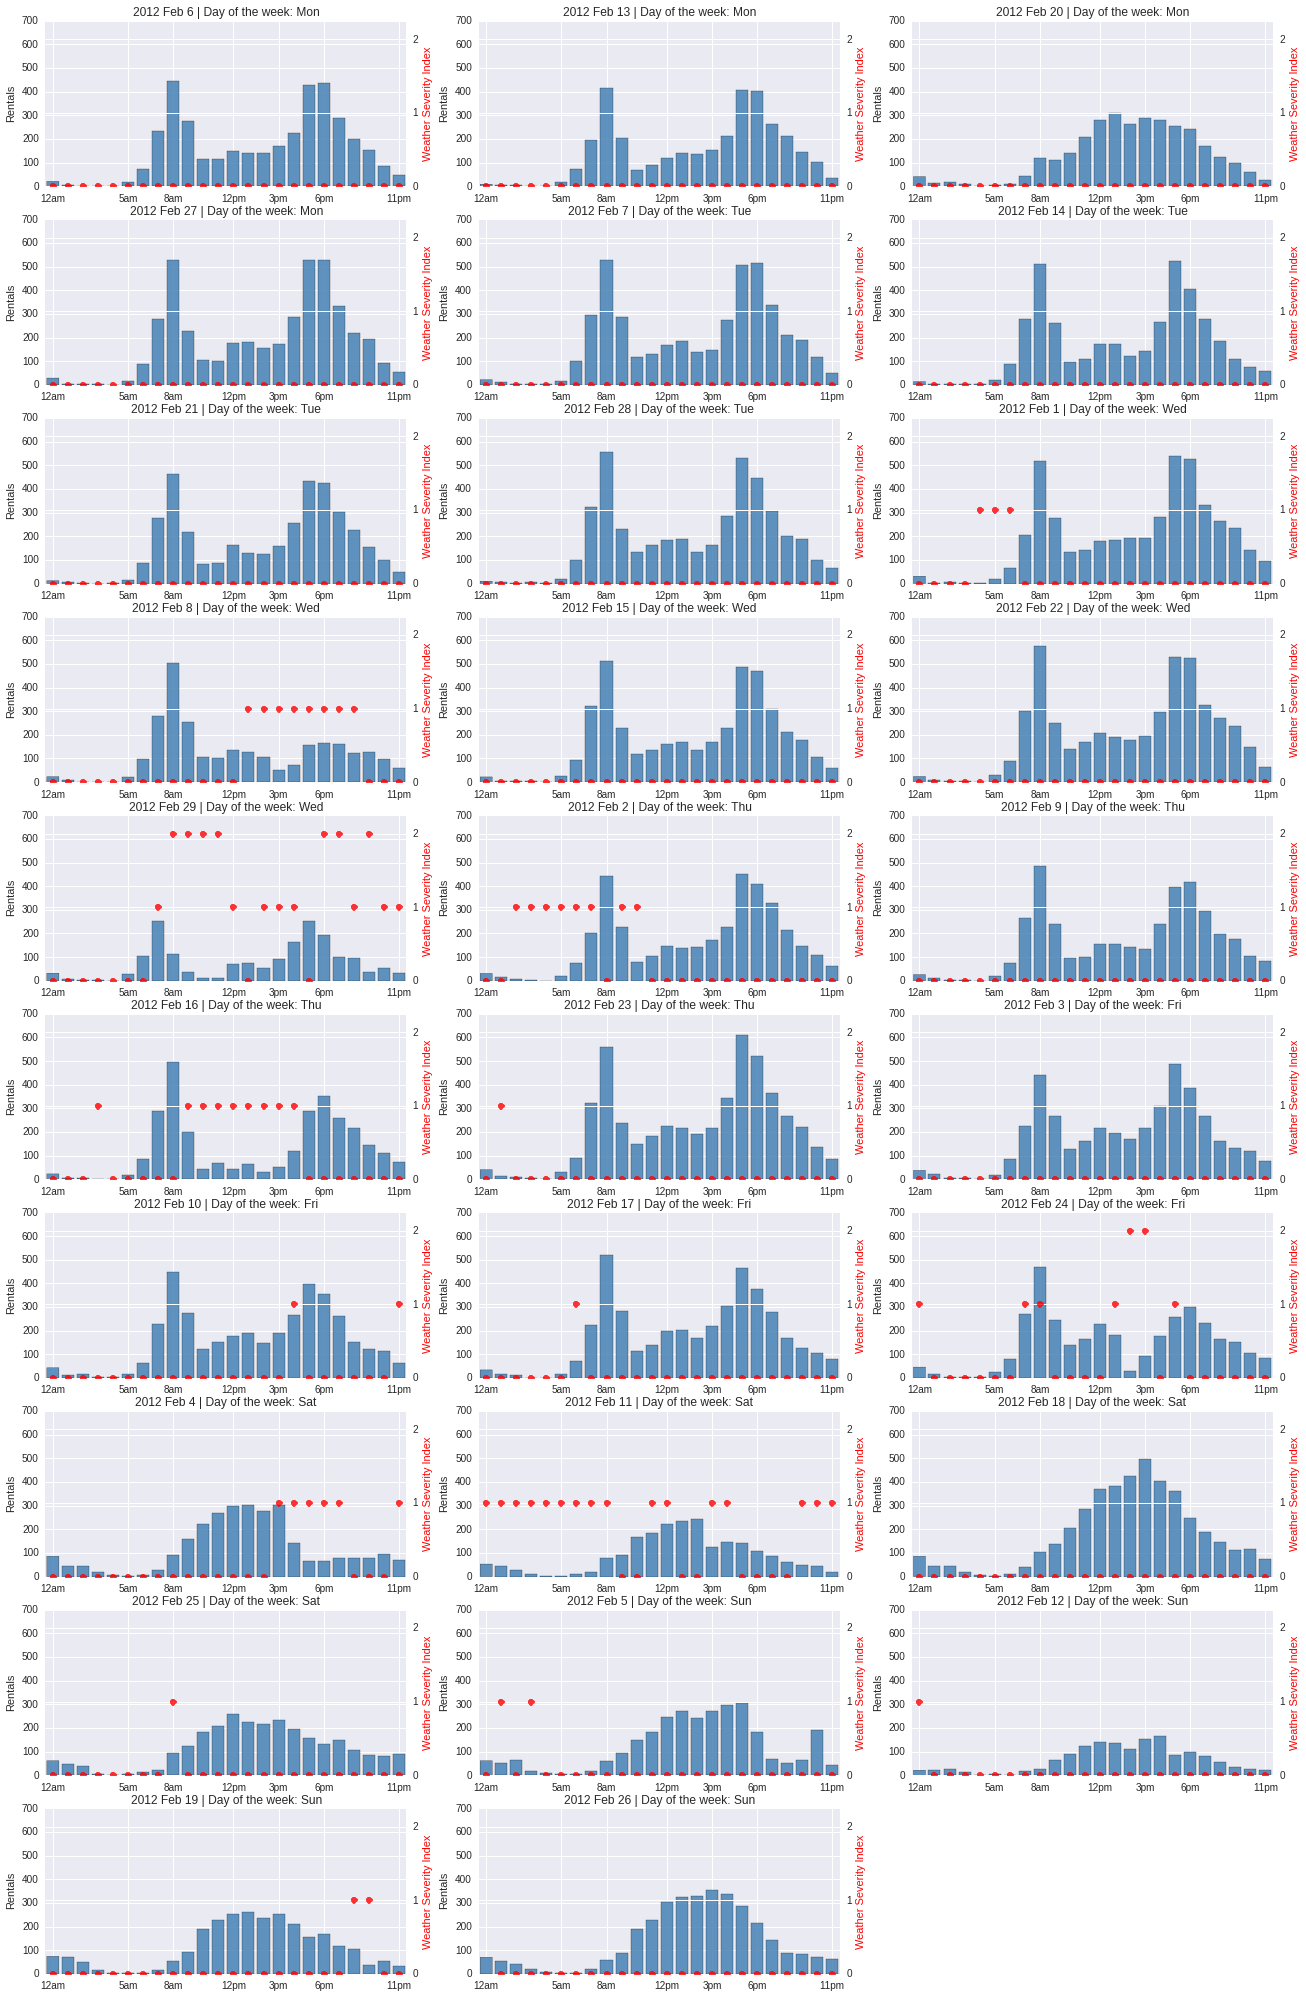

In [28]:
figure = plt.figure(figsize=(22, 35))
#figure = plt.figure()
year='2012'
month='2'

#get weeks relative to the year
bikeData=bike[bikeYear[year] & bikeMonth[month]]
wxData=wx[wxYear[year] & wxMonth[month]]
weeksOfYear=bikeData.startDate.dt.week.unique()

i=1
#now, find day=0 for each week, then day=1 for each week
for weekDay in range(0,7+1):
    bikeDataForADay=bikeData[bikeData.startDate.dt.weekday==weekDay]
    wxDataForADay=wxData[wxData.date.dt.weekday==weekDay]
    for week in weeksOfYear:
        bikeDataForThisDayInThisWeek=bikeDataForADay[bikeDataForADay.startDate.dt.week==week]
        wxDataForThisDayInThisWeek=wxDataForADay[wxDataForADay.date.dt.week==week]
        if len(bikeDataForThisDayInThisWeek)>0:
            ax1 = figure.add_subplot(10, 3, i)


            ax1.hist(bikeDataForThisDayInThisWeek.startDate.dt.hour.values,alpha=0.85,color='steelblue',bins=np.arange(25)-0.5,rwidth=0.8)
                   
            ax1.set_title(year+' '+monthNames[int(month)-1]+ ' '+\
                           str(min(bikeDataForThisDayInThisWeek.startDate.dt.day)) +' | Day of the week: '+dayNum2dayStr[weekDay])
            ax1.set_ylim(0,700)
            ax1.set_xlim(0,23)
            ax1.set_ylabel('Rentals')
            ax1.set_xticks([0,5,8,12,15,18,23])
            ax1.set_xticklabels(['12am','5am','8am','12pm','3pm','6pm','11pm'])
            
            ax2=ax1.twinx()
            #sometimes there is more than 1 wx event per hour, so pick the one that repeats the most
            for hour in wxDataForThisDayInThisWeek.date.dt.hour.unique():
                result=wxDataForThisDayInThisWeek[wxDataForThisDayInThisWeek.date.dt.hour==hour].conditions
                if len(result)==1:
                    eventSeverity=wxEventDict[result.values[0]]

                else:
                    #if there is more than one wx event in that hour, 
                    #pick the most severe
                    eventSeverity=0
                    for resultFound in result.values:
                        eventSeverity=max(eventSeverity,wxEventDict[resultFound])

                ax2.plot(hour,eventSeverity,'--ro',alpha=0.8)
                ax2.set_ylim(0,2.25)
                ax2.set_ylabel('Weather Severity Index',color='r')
                ax2.set_yticks([0,1,2])
            
            i+=1
plt.show()

A-ha! There definetely is a weather event with a Severity Index greater than 0 during those Wednesdays with strange ridership patterns. 

Before we analyze this case, we must mention that in some cases where the Index is 1, the ridership pattern could have been unnafected (See Feb. 2nd, 2012). So, WHY and WHEN could it happen? This is what we think:

1) The weather data we were able to get comes from the Wasington-Reagan International Airport. This means that we are assuming that what happens at DCA also happens where uses ride their Capital Bikeshare bike. (e.g. it could be lightly snowing at DCA, but in Alexandria, VA it is just overcast, and therefore users are riding their bike)

2) We have assumed that the weather event is affecting enought users that the change in behavior (# of rentals per hour) is captured through the histograms above.

3) We simply assumed the severity was greater than user's perception. (e.g. light rain is really 0). 

In the Feb. 2nd case, we checked the weather event and it was "light rain" BUT it did not affect the Bikeshare users. However, on Feb 4th, the same weather event was recorded ("light rain") and it did affect ridership. This leads us to believe that it was case #1 and #2 above. What would be a good way to assess assumption #1 above? Compare it to other weather reports in Downtown DC. If they match most of the time then we could take DCA's weather as DC's weather. Unfortunately, in Feb 4th, the weather seemed to be different on those two locations.

Let's now refocus our attention to the weather events that affected user behavior. Let's again look at the Wednesdays of February 2012:

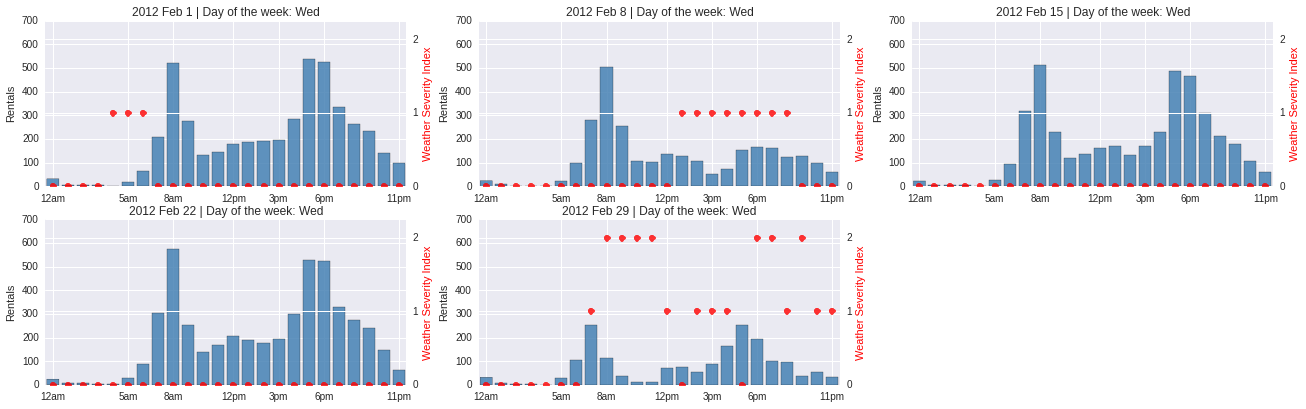

In [29]:
figure = plt.figure(figsize=(22, 35))
#figure = plt.figure()
year='2012'
month='2'

#get weeks relative to the year
bikeData=bike[bikeYear[year] & bikeMonth[month]]
wxData=wx[wxYear[year] & wxMonth[month]]
weeksOfYear=bikeData.startDate.dt.week.unique()

i=1
#now, find day=0 for each week, then day=1 for each week
for weekDay in [2]:
    bikeDataForADay=bikeData[bikeData.startDate.dt.weekday==weekDay]
    wxDataForADay=wxData[wxData.date.dt.weekday==weekDay]
    for week in weeksOfYear:
        bikeDataForThisDayInThisWeek=bikeDataForADay[bikeDataForADay.startDate.dt.week==week]
        wxDataForThisDayInThisWeek=wxDataForADay[wxDataForADay.date.dt.week==week]
        if len(bikeDataForThisDayInThisWeek)>0:
            ax1 = figure.add_subplot(10, 3, i)


            ax1.hist(bikeDataForThisDayInThisWeek.startDate.dt.hour.values,alpha=0.85,color='steelblue',bins=np.arange(25)-0.5,rwidth=0.8)
                   
            ax1.set_title(year+' '+monthNames[int(month)-1]+ ' '+\
                           str(min(bikeDataForThisDayInThisWeek.startDate.dt.day)) +' | Day of the week: '+dayNum2dayStr[weekDay])
            ax1.set_ylim(0,700)
            ax1.set_xlim(0,23)
            ax1.set_ylabel('Rentals')
            ax1.set_xticks([0,5,8,12,15,18,23])
            ax1.set_xticklabels(['12am','5am','8am','12pm','3pm','6pm','11pm'])
            
            ax2=ax1.twinx()
            #sometimes there is more than 1 wx event per hour, so pick the one that repeats the most
            for hour in wxDataForThisDayInThisWeek.date.dt.hour.unique():
                result=wxDataForThisDayInThisWeek[wxDataForThisDayInThisWeek.date.dt.hour==hour].conditions
                if len(result)==1:
                    eventSeverity=wxEventDict[result.values[0]]

                else:
                    #if there is more than one wx event in that hour, 
                    #pick the most severe
                    eventSeverity=0
                    for resultFound in result.values:
                        eventSeverity=max(eventSeverity,wxEventDict[resultFound])

                ax2.plot(hour,eventSeverity,'--ro',alpha=0.8)
                ax2.set_ylim(0,2.25)
                ax2.set_ylabel('Weather Severity Index',color='r')
                ax2.set_yticks([0,1,2])
            
            i+=1
plt.show()

Beautiful...look how SIMILAR days that are "normal" are. 

Also, look how when there are weather events with an index of 1 or 2, the number of rentals decreases. 

If one looks at Feb 8's morning, it seems to be a normal busy Monday like any other in that month. However, as the afternoon approaches , weather with severity index of 1 takes place. The end result? A lower-than-expected ridership in the afternoon from 500 to less than 200 rentals/hr.

A look at the weather dataframe confirms the weather event (and how overcast skies developed into possible cumulonimbus clouds bringing some rain):

In [30]:
tmp=wx[wxYear['2012'] & wxMonth['2'] & (wx.date.dt.day==8)]
tmp[['conditions','timeEST']]

,conditions,timeEST
9108,Scattered Clouds,12:52 AM
9109,Scattered Clouds,1:52 AM
9110,Scattered Clouds,2:52 AM
9111,Mostly Cloudy,3:52 AM
9112,Overcast,4:52 AM
9113,Overcast,5:52 AM
9114,Overcast,6:52 AM
9115,Overcast,7:52 AM
9116,Overcast,8:52 AM
9117,Overcast,9:52 AM


Indeed, there was "light rain" somewhere where users rode their bike and it disrupted their normal behavior. 

Just for sanity check, let's look at any other month (Sept) when ridership is high. 

(Note: we should have put these lines of code in a function since we are repeating the code over and over, but we didn't)

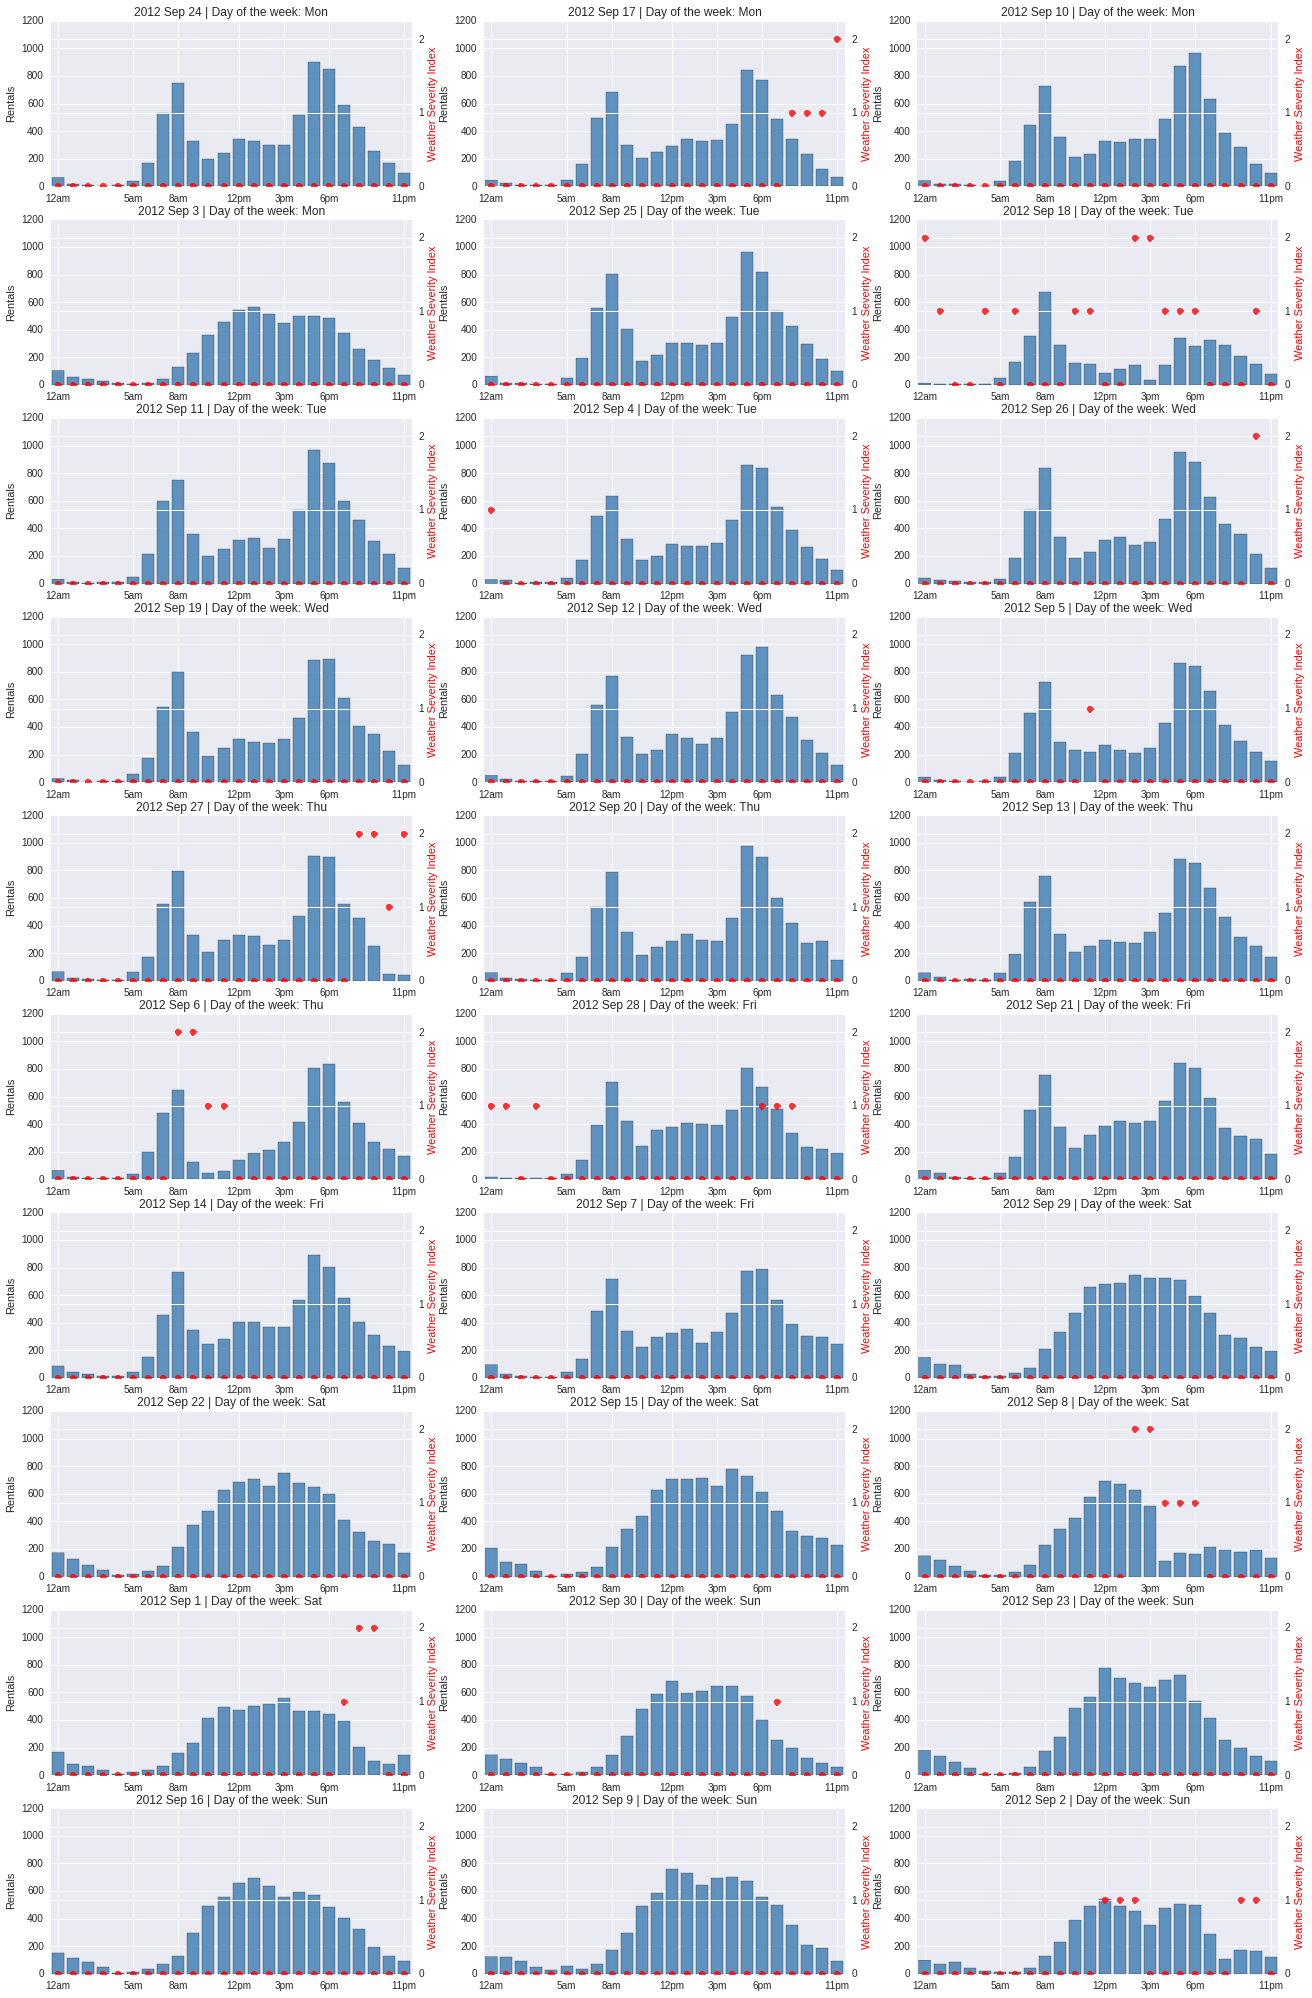

In [31]:
figure = plt.figure(figsize=(22, 35))
#figure = plt.figure()
year='2012'
month='9'

#get weeks relative to the year
bikeData=bike[bikeYear[year] & bikeMonth[month]]
wxData=wx[wxYear[year] & wxMonth[month]]
weeksOfYear=bikeData.startDate.dt.week.unique()

i=1
#now, find day=0 for each week, then day=1 for each week
for weekDay in range(0,7+1):
    bikeDataForADay=bikeData[bikeData.startDate.dt.weekday==weekDay]
    wxDataForADay=wxData[wxData.date.dt.weekday==weekDay]
    for week in weeksOfYear:
        bikeDataForThisDayInThisWeek=bikeDataForADay[bikeDataForADay.startDate.dt.week==week]
        wxDataForThisDayInThisWeek=wxDataForADay[wxDataForADay.date.dt.week==week]
        if len(bikeDataForThisDayInThisWeek)>0:
            ax1 = figure.add_subplot(10, 3, i)


            ax1.hist(bikeDataForThisDayInThisWeek.startDate.dt.hour.values,alpha=0.85,color='steelblue',bins=np.arange(25)-0.5,rwidth=0.8)
                   
            ax1.set_title(year+' '+monthNames[int(month)-1]+ ' '+\
                           str(min(bikeDataForThisDayInThisWeek.startDate.dt.day)) +' | Day of the week: '+dayNum2dayStr[weekDay])
            ax1.set_ylim(0,1200)
            ax1.set_xlim(0,23)
            ax1.set_ylabel('Rentals')
            ax1.set_xticks([0,5,8,12,15,18,23])
            ax1.set_xticklabels(['12am','5am','8am','12pm','3pm','6pm','11pm'])
            
            ax2=ax1.twinx()
            #sometimes there is more than 1 wx event per hour, so pick the one that repeats the most
            for hour in wxDataForThisDayInThisWeek.date.dt.hour.unique():
                result=wxDataForThisDayInThisWeek[wxDataForThisDayInThisWeek.date.dt.hour==hour].conditions
                if len(result)==1:
                    eventSeverity=wxEventDict[result.values[0]]

                else:
                    #if there is more than one wx event in that hour, 
                    #pick the most severe
                    eventSeverity=0
                    for resultFound in result.values:
                        eventSeverity=max(eventSeverity,wxEventDict[resultFound])

                ax2.plot(hour,eventSeverity,'--ro',alpha=0.8)
                ax2.set_ylim(0,2.25)
                ax2.set_ylabel('Weather Severity Index',color='r')
                ax2.set_yticks([0,1,2])
            
            i+=1
plt.show()

Excellent. It looks like our assessment of "severity" isn't that bad after all, and our assumptions about DCA's weather are true most of the time.

September 8 is another great case of weather interfering with ridership totals. 

Let's focus on this month's Tuesdays:

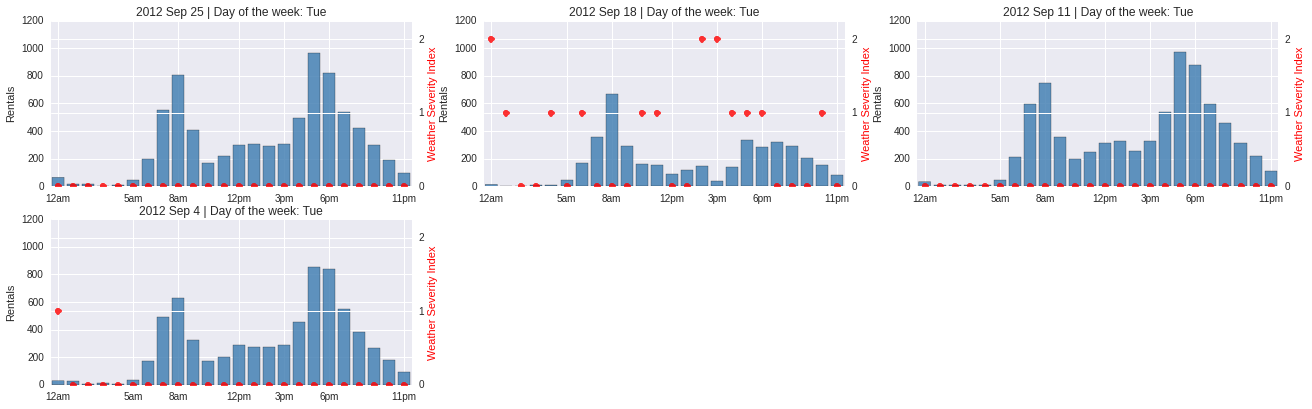

In [32]:
figure = plt.figure(figsize=(22, 35))
#figure = plt.figure()
year='2012'
month='9'

#get weeks relative to the year
bikeData=bike[bikeYear[year] & bikeMonth[month]]
wxData=wx[wxYear[year] & wxMonth[month]]
weeksOfYear=bikeData.startDate.dt.week.unique()

i=1
#now, find day=0 for each week, then day=1 for each week
for weekDay in [1]:
    bikeDataForADay=bikeData[bikeData.startDate.dt.weekday==weekDay]
    wxDataForADay=wxData[wxData.date.dt.weekday==weekDay]
    for week in weeksOfYear:
        bikeDataForThisDayInThisWeek=bikeDataForADay[bikeDataForADay.startDate.dt.week==week]
        wxDataForThisDayInThisWeek=wxDataForADay[wxDataForADay.date.dt.week==week]
        if len(bikeDataForThisDayInThisWeek)>0:
            ax1 = figure.add_subplot(10, 3, i)


            ax1.hist(bikeDataForThisDayInThisWeek.startDate.dt.hour.values,alpha=0.85,color='steelblue',bins=np.arange(25)-0.5,rwidth=0.8)
                   
            ax1.set_title(year+' '+monthNames[int(month)-1]+ ' '+\
                           str(min(bikeDataForThisDayInThisWeek.startDate.dt.day)) +' | Day of the week: '+dayNum2dayStr[weekDay])
            ax1.set_ylim(0,1200)
            ax1.set_xlim(0,23)
            ax1.set_ylabel('Rentals')
            ax1.set_xticks([0,5,8,12,15,18,23])
            ax1.set_xticklabels(['12am','5am','8am','12pm','3pm','6pm','11pm'])
            
            ax2=ax1.twinx()
            #sometimes there is more than 1 wx event per hour, so pick the one that repeats the most
            for hour in wxDataForThisDayInThisWeek.date.dt.hour.unique():
                result=wxDataForThisDayInThisWeek[wxDataForThisDayInThisWeek.date.dt.hour==hour].conditions
                if len(result)==1:
                    eventSeverity=wxEventDict[result.values[0]]

                else:
                    #if there is more than one wx event in that hour, 
                    #pick the most severe
                    eventSeverity=0
                    for resultFound in result.values:
                        eventSeverity=max(eventSeverity,wxEventDict[resultFound])

                ax2.plot(hour,eventSeverity,'--ro',alpha=0.8)
                ax2.set_ylim(0,2.25)
                ax2.set_ylabel('Weather Severity Index',color='r')
                ax2.set_yticks([0,1,2])
            
            i+=1
plt.show()

Notice how similar Tuesdays are for the Month of September....except when there is weather with an index above 0. 

In this case, weather affected ridership especially in the afternoon. For instane, ridership at the peak-time of 5pm for September 2012 was always above 800 rentals/hr. In Sept 18, it was less than 400 rentals/hr.

Let's recapitulate, shall we?

1) We noticed a correlation (possibly causation) between air temperature and # of rentals per month per station and # of rentals per station per week. We can argue in favor of causation by comparing ridership at 8am during a winter and non-winter month. Since ridership is lower and the "daylight" variable is still the same (i.e. it is not dark) we can discard the option that riders highly prefer riding in daylight only. 

2) We were able to overlay weather events (using our own Weather Severity Index) and observed how high severity index weather events affect the number of rentals/hr.

3) We have observed how ridership is distributed on a per month and hour basis. 

So, What is left to do? What could WE do with these findings? Let's see if we can convert the findings into actionable results. Results that our customers can use to make the determination of establishing a Bikeshare system somewhere else in this world. 

One thing we could try to do is to build a few linear models using linear regression.

In any case, these are the models/regressors we have in mind:

Model 1: Num of rentals ~ Temperature + error (using the monthly averaged temperature vs. num rentals per month)
Model 2: Num of rentals ~ Temperature + error (using the weekly averaged temperature vs. num rentals per week)

Now, there could be a problem in the models above: number of rentals will depend on the pool of people available and able to use the Bikeshare system and the number of stations. In other words, if we take the temperature of, say, Luxemburg, the model may overestimate the number of rentals since the DC,MD, and VA area where the system operates has a population of over 1 million vs. 562,958 in Luxemburg. What does this mean? That we have to somehow normalize the number of rentals per habitant, in addition to the number of stations. Also, another normalization factor is the number of available bikes. For this, we have decided to use the number of stations available as a proxy for the number of bikes. 

Another possible complication is that the penetration rate of the Bikeshare system may be much, much higher in a city with a lower population relative to DC, thus having more users. Our models won't take this into account. We will assume that "if the build it, customers will come" in the same proportions as they did in DC.  

These are the major cities/areas where Capital Bikeshare operates and the population in 2012:

* Arlington County,VA (221,275)
* Washington D.C. (635,040)
* Bethesda, MD (60,858 for year 2010)
* Silver Spring, MD (71,452 for year 2010)

Total Population 2012= 988,625

This is the number we will use to normalize the rentals/hr. This method isn't perfect but makes sense if one assumes that the same proportion of habitants in a city would use a bike system.

We have more models in mind, but let's defer that discussion until after we construct model 1 and 2. 

Let's define the functions we will use first:

In [33]:
def lm( formula, data=None):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")

    result = {}
    result[ "formula"] = formula
    result[ "n"] = data.shape[ 0]

    y, X = patsy.dmatrices( formula, data, return_type="matrix")
    model = linear.LinearRegression( fit_intercept=False).fit( X, y)

    result[ "coefficients"] = model.coef_[ 0]

    result[ "r^2"] = model.score( X, y)
    
    y_hat = model.predict( X)
    result[ "residuals"] = y - y_hat
    
    sum_squared_error = sum([ e**2 for e in result[ "residuals"]])[ 0]

    n = len( result[ "residuals"])
    k = len( result[ "coefficients"])
    
    result[ "sigma^2"] = np.sqrt( sum_squared_error / (n - k))
    
    return result
def bootstrap_lm( formula, data=None, samples=100):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")
    
    bootstrap_results = {}
    bootstrap_results[ "formula"] = formula

    variables = map( lambda x: x.strip(), formula.split("~")[1].split( "+"))
    variables = ["intercept"] + variables
    bootstrap_results[ "variables"] = variables
    
    coeffs = []
    sigmas = []
    rs = []

    n = data.shape[ 0]
    bootstrap_results[ "n"] = n
    
    for i in xrange( samples):
        sampling_indices = [ i for i in [random.randint(0, n - 1) for _ in xrange( 0, n)]]
        sampling = data.loc[ sampling_indices]
        
        results = lm( formula, data=sampling)
        coeffs.append( results[ "coefficients"])
        sigmas.append( results[ "sigma^2"])
        rs.append( results[ "r^2"])
    
    coeffs = pd.DataFrame( coeffs, columns=variables)
    sigmas = pd.Series( sigmas, name="sigma^2")
    rs = pd.Series( rs, name="r^2")

    bootstrap_results[ "resampled_coefficients"] = coeffs
    bootstrap_results[ "resampled_sigma^2"] = sigmas
    bootstrap_results[ "resampled_r^2"] = rs
    
    result = lm( formula, data=data)
    
    bootstrap_results[ "residuals"] = result[ "residuals"]
    bootstrap_results[ "coefficients"] = result[ "coefficients"]
    bootstrap_results[ "sigma^2"] = result[ "sigma^2"]
    bootstrap_results[ "r^2"] = result[ "r^2"]
    return bootstrap_results

def describe_bootstrap_fit( result):
    print "regression: ", result[ "formula"]
    print "n: ", result[ "n"]
    print "----------"
    
    
    bounds = result[ "resampled_coefficients"].quantile([0.025, 0.975])
    bounds = bounds.transpose()
    bounds = bounds.values.tolist()

    for variable, coefficient, bound in zip( result[ "variables"], result["coefficients"], bounds):
        print variable + ": ", coefficient, bound
    print "----------"
    
    sigma_bounds = stats.mstats.mquantiles( result[ "resampled_sigma^2"], [0.025, 0.975])
    print "sigma^2", result[ "sigma^2"], sigma_bounds

    r_bounds = stats.mstats.mquantiles( result[ "resampled_r^2"], [0.025, 0.975])
    print "R^2", result[ "r^2"], r_bounds

Let's start with model #1. Unfortunately, we did not save the data from that step, so we will have to re-run the code (we just got bit again for not writing a function that does this!)...

In [34]:
data={}
data['numRentalsPerMonthPerStation']=[]
data['airTempF']=[]
year='2012'
for month in months:
    data['numRentalsPerMonthPerStation'].append(len(bike[bikeYear[year] & bikeMonth[month]]) \
                                               / numStations[year+month])
    data['airTempF'].append(np.mean(wx.temperatureF[wxYear[year] & wxMonth[month]]))
dataForModel1=pd.DataFrame(data)

Remember, we have to normalize the data using the total DMV area population and number of available stations:

In [35]:
POPULATION_DMV_AREA = 988625
dataForModel1['numRentalsPerMonthPerStationPer100kPeople']=dataForModel1.numRentalsPerMonthPerStation.values/(POPULATION_DMV_AREA/100000)


Let's look at the dataframe to make sure things look OK:

In [36]:
dataForModel1.describe()

,airTempF,numRentalsPerMonthPerStation,numRentalsPerMonthPerStationPer100kPeople
count,12.000000,12.000000,12.000000
mean,60.911252,990.031877,100.142306
std,15.015752,213.122449,21.557461
min,40.296696,651.121053,65.861277
25%,45.712234,776.572066,78.550721
50%,59.177416,1089.076480,110.160726
75%,73.150191,1160.262342,117.361218
max,82.703825,1177.906977,119.145983


Given the ranges, we don't think there is a need to scale or mean center the data. Let's build the model and use the bootstrap method to get the credible intervals for the betas:

regression:  numRentalsPerMonthPerStationPer100kPeople ~ airTempF
n:  12
----------
intercept:  21.7787946236 [-1.6123087473164637, 87.75599918831696]
airTempF:  1.28651947445 [0.39844558135741204, 1.749196169005425]
----------
sigma^2 10.0344648636 [  2.52839616  11.62144432]
R^2 0.803029799291 [ 0.54696998  0.9486556 ]


/home/aj/miniconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


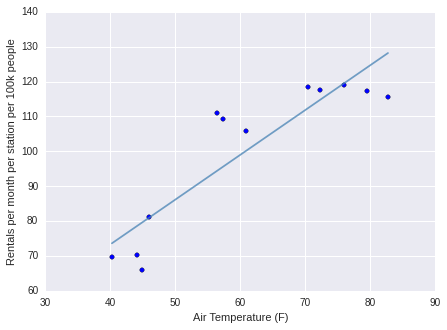

In [37]:
model1=bootstrap_lm('numRentalsPerMonthPerStationPer100kPeople ~ airTempF',dataForModel1)
describe_bootstrap_fit(model1)

figure = plt.figure(figsize=(7,5))

axes = figure.add_subplot(1, 1, 1)

x=dataForModel1.airTempF
y=dataForModel1.numRentalsPerMonthPerStationPer100kPeople
axes.scatter(x,y)
xs=np.linspace(min(x),max(x))
betas=model1['coefficients']

axes.plot(xs, [betas[ 0] + betas[ 1] * n for n in xs], '-', color="steelblue", alpha=0.75)
axes.set_xlabel('Air Temperature (F)')
axes.set_ylabel('Rentals per month per station per 100k people')

Let's plot the residuals since we are seeing pattern of over-estimatating at the lower and higher end of the temperatures, while under-estimating in the middle. 

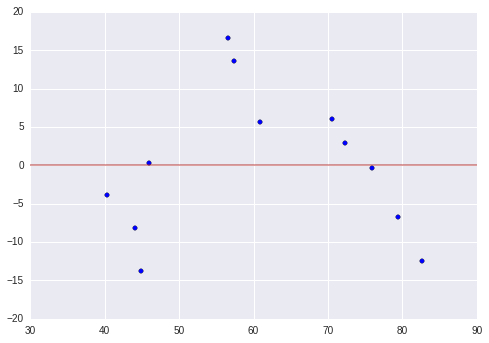

In [38]:
plt.scatter(x,model1['residuals'])
plt.axhline(y=0.0,xmin=0,xmax=90, c="firebrick", alpha=0.5)
plt.show()

There is definitely a pattern, as we discussed above. The residuals follow an inverted parabolla. Since this uses monthly ridership data AND we have others models to build, we won't do any data transformation here to alleviate the problem above. 

Let's work with model #2, which uses weekly ridership. 

In [39]:
#Get weekly ridership data

data={}
data['numRentalsPerWeekPerStation']=[]
data['airTempF']=[]
year='2012'

#Get subset of dataframe (speeds up comparisons)
weeks=sorted(bike.startDate.dt.weekofyear.unique())
bikeSubset=bike[bikeYear[year]]
wxSubset=wx[wxYear[year]]

for week in weeks:
    theMonth=int(np.ceil(week/4.34))
    sel= bikeSubset.startDate.dt.weekofyear==week
    data['numRentalsPerWeekPerStation'].append(len(bikeSubset[sel])\
                                    /numStations[year+str(theMonth)])
    sel= wxSubset.date.dt.weekofyear==week
    data['airTempF'].append(np.mean(wxSubset.temperatureF[sel]))

dataForModel2=pd.DataFrame(data)

In [40]:
dataForModel2['numRentalsPerWeekPerStationPer100kPeople']=dataForModel2.numRentalsPerWeekPerStation.values/(POPULATION_DMV_AREA/100000)

In [41]:
dataForModel2.describe()

,airTempF,numRentalsPerWeekPerStation,numRentalsPerWeekPerStationPer100kPeople
count,52.000000,52.000000,52.000000
mean,61.080751,228.249724,23.087594
std,15.063259,52.000270,5.259858
min,35.639336,68.494737,6.928283
25%,47.267626,184.739756,18.686535
50%,61.640263,254.186282,25.711092
75%,74.252269,265.501408,26.855624
max,88.565608,292.726744,29.609482


Before building the model, let's see how the data looks like in a scatter plot:

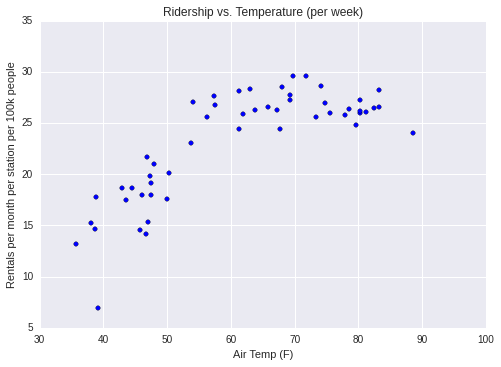

In [42]:
plt.scatter(dataForModel2.airTempF,dataForModel2.numRentalsPerWeekPerStationPer100kPeople)
plt.xlabel('Air Temp (F)')
plt.ylabel('Rentals per month per station per 100k people')
plt.title('Ridership vs. Temperature (per week)')

We can see how there is some non-linearity in the relationship between the variables above. For example, if the temperature doubles from 40 to 80 F, the ridership per station per 100k people more than doubles. This suggests that our model could benefit from a data transformation (possibly a cuadratic term). Let's try that:

In [43]:
dataForModel2['airTempF_sqrd']=np.power(dataForModel2['airTempF'],2)

regressors=['airTempF','airTempF_sqrd']

model2=bootstrap_lm("numRentalsPerWeekPerStationPer100kPeople ~ "+"+".join(regressors),dataForModel2)
describe_bootstrap_fit(model2)

regression:  numRentalsPerWeekPerStationPer100kPeople ~ airTempF+airTempF_sqrd
n:  52
----------
intercept:  -37.5131862762 [-54.510653953424, -25.67224401908519]
airTempF:  1.79205043461 [1.4137942698055328, 2.3567584057433706]
airTempF_sqrd:  -0.0123587420335 [-0.01664329462013315, -0.009448677628514621]
----------
sigma^2 2.25680005068 [ 1.65640991  2.68187626]
R^2 0.823125980577 [ 0.77842322  0.88073621]


None of the credible intervals for the coefficients include zero. Let's look at the residuals:

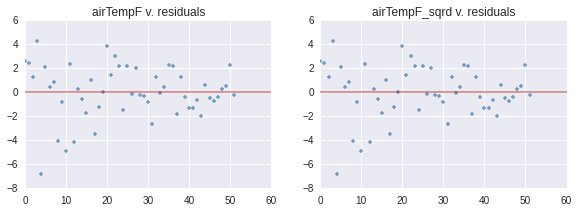

In [44]:
figure = plt.figure(figsize=(15,3))

plots = len( regressors)
rows = (plots // 3) + 1

for i, variable in enumerate( regressors):
    axes = figure.add_subplot(rows, 3, i + 1)
    keyed_values = sorted( zip( dataForModel2[ variable].values, model2[ "residuals"]), key=lambda x: x[ 0])
    residuals = map( lambda x: x[ 1][ 0], keyed_values)

    #axes.plot(dataForModel[ variable].values, residuals, '.', color="steelblue", alpha=0.75)
    axes.plot(range(0, model2[ "n"]), residuals, '.', color="steelblue", alpha=0.75)
    axes.axhline(y=0.0, xmin=0, xmax=model2[ "n"], c="firebrick", alpha=0.5)
    axes.set_title( variable + " v. residuals")

When doing linear regression, some assumptions are made. Judging by the plots above, it seems like we are in violation of equal variance of erros (observe how the variance seems to be lower on the right side). In terms of the validity, we are not so sure. We don't think this model can be used for all possible temperature values. In other words, it will be important to restrict the temperature range to those found in the data. Once this is stated, we think it is a useful model FOR the 2012's DC Bikeshare system.

Let's interpret the model:

intercept:  -37.5131862762 [-50.630944090081684, -26.573522957678097]

airTempF:  1.79205043461 [1.417934996863572, 2.206452685302418]

airTempF_sqrd:  -0.0123587420335 [-0.015678416564902112, -0.009369508948276789]

sigma^2 2.25680005068 [ 1.70287244  2.7746002 ]

R^2 0.823125980577 [ 0.77928004  0.87306291]

In this case, the intercept does not have a meaningful interpretation : we do not necessarily expect -30 rentals per week per station per 100k people when the temperature is 0F). 

Note that because we have added a second regressor which is the first one squared, we are not sure that beta1 can be interpreted in isolation of beta2 and its regressor. We will try, anyways: 

The predictive interpretation for the second coefficient, beta1, is that we should expect a change of 1.79 rentals per week per station per 100k people for a unit change in the temperature. For beta2, we are not so sure how to interpret the value, but like we said, we will try:

We can say that for every unit change of the regressor airTempF_sqrd (squared) away from the vertex (remember, the equation is y=b0+b1x+b2x^2, where the vertex is located at b0 - b2/4*b1), we should expect the number of rentals per week per station per 100k people to change by 0.012. Note here that a unit change does not equate to a 1 degree difference as in the beta1 case. 

Let's switch gears a bit:
During the EDA process above, we thought we would be able to use the "Weather Severity Index". While we think it was interesting to do such analysis, we feel the index is not needed. The change in ridership due to weather is much more strongly dependent on the temperature than on some sporadic rain or snow for a few times in a week (we ran the numbers and when it rains, ridership does change intra-day but does not contribute much to the totals.)

Also, if we make a few additions to the model (which we will do below), we can answer the question of "How many bike riders will I have if Company X establishes a similar system in a city". We have to figure out a way of introducing the year component in the model.

Let's plot the predictions for a wide range of temperature vaues using Model2, and plot data for 2012:

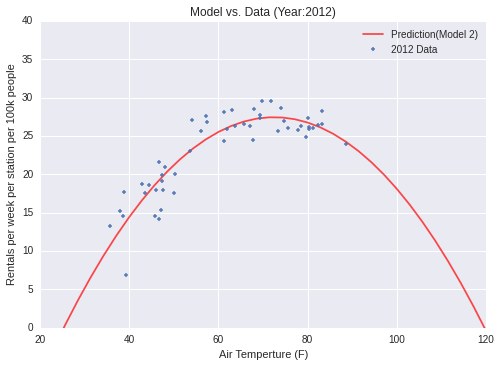

In [45]:
x=np.linspace(-20,120)
y=[]
for tempF in x:
    y.append(np.dot(model2['coefficients'],[1,tempF,np.power(tempF,2)]))
plt.plot(x,y,'r',alpha=0.7)

y=dataForModel2.numRentalsPerWeekPerStationPer100kPeople
x=dataForModel2.airTempF
plt.plot(x,y,'.',alpha=0.9)

plt.title('Model vs. Data (Year:2012)')
plt.legend(['Prediction(Model 2)','2012 Data'])    
plt.ylim(0,40)
plt.xlim(20,120)
plt.ylabel('Rentals per week per station per 100k people')
plt.xlabel('Air Temperture (F)')
plt.show()

Our model show some very interesting. There is an optimal temperature when riders like to ride their bikes. Such optimal temperature is the vertex of our quadratic function. In this case, it is somewhere around 75F. 

Let's now build a model that uses data from 2012 and 2013, and uses the year information as a new regressor:

In [46]:
#get data for year 2013

#Get weekly ridership data

data={}
data['numRentalsPerWeekPerStation']=[]
data['airTempF']=[]
year='2013'

#Get subset of dataframe (speeds up comparisons)
weeks=sorted(bike.startDate.dt.weekofyear.unique())
bikeSubset=bike[bikeYear[year]]
wxSubset=wx[wxYear[year]]

for week in weeks:
    theMonth=int(np.ceil(week/4.34))
    sel= bikeSubset.startDate.dt.weekofyear==week
    data['numRentalsPerWeekPerStation'].append(len(bikeSubset[sel])\
                                    /numStations[year+str(theMonth)])#could also do sum(sel) but seems slower
    sel= wxSubset.date.dt.weekofyear==week
    data['airTempF'].append(np.mean(wxSubset.temperatureF[sel]))

data2013=pd.DataFrame(data)

These are the major cities where Capital Bikeshare operates and the population in 2013 and 2012:
* Arlington County,VA (224,906)(221,275)
* Washington D.C. (649,111)(635,040)
* Bethesda, MD (63,374) (60,858 for year 2010)
* Silver Spring, MD (76,716)(71,452 for year 2010)

Total Population 2012= 988,625

Total Population 2013=1,014,107 (an increase of 2.577519282% from 2012)


In [47]:
#Get weekly ridership data

data={}
data['numRentalsPerWeekPerStationPer100kPeople']=[]
data['airTempF']=[]
data['yearDiff']=[]
yearBase=2012;
years=['2012','2013']

weeks=sorted(bike.startDate.dt.weekofyear.unique())

for year in years:
    
    bikeSubset=bike[bikeYear[year]]
    wxSubset=wx[wxYear[year]]

    for week in weeks:
        theMonth=int(np.ceil(week/4.34))
        sel= bikeSubset.startDate.dt.weekofyear==week
        theLenght=len(bikeSubset[sel])
        theStations=numStations[year+str(theMonth)]
        if year=='2013':
            thePopulation=1014107/100000
            data['numRentalsPerWeekPerStationPer100kPeople'].append(theLenght*(1/theStations)*(1/thePopulation))           
        else:
            thePopulation=988625/100000
            data['numRentalsPerWeekPerStationPer100kPeople'].append(theLenght*(1/theStations)*(1/thePopulation))           

          
        sel= wxSubset.date.dt.weekofyear==week
        data['airTempF'].append(np.mean(wxSubset.temperatureF[sel]))
        data['yearDiff'].append(int(year)-yearBase)
    
dataForModel3=pd.DataFrame(data)

This model uses data for both years, including the new regressor "yearDiff" (year difference with 2012 as the base)

In [48]:
dataForModel3['airTempF_sqrd']=np.power(dataForModel3['airTempF'],2)

regressors=['airTempF','airTempF_sqrd','yearDiff']

model3=bootstrap_lm("numRentalsPerWeekPerStationPer100kPeople ~ "+"+".join(regressors),dataForModel3)
describe_bootstrap_fit(model3)

regression:  numRentalsPerWeekPerStationPer100kPeople ~ airTempF+airTempF_sqrd+yearDiff
n:  104
----------
intercept:  -22.1485677093 [-35.50027492408366, -12.322942157085716]
airTempF:  1.2696650122 [0.9255845872234167, 1.725186399009945]
airTempF_sqrd:  -0.00817421975671 [-0.011657684861497947, -0.005312471051243146]
yearDiff:  -1.82866525104 [-2.9229450528925947, -0.7530245471607223]
----------
sigma^2 2.80818329427 [ 2.19968671  3.3102056 ]
R^2 0.768903480512 [ 0.70406044  0.84532173]


None of the credible intervals include zero. The error variance is not too big in our case (avg error of 2.8 rentals per week per station per 100k people). R^2 isn't perfect, but let's look at the residuals and how our model fits the data:

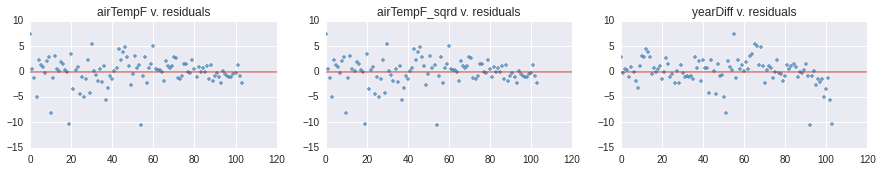

In [49]:
figure = plt.figure(figsize=(15,5))

plots = len( regressors)
rows = (plots // 3) + 1

for i, variable in enumerate( regressors):
    axes = figure.add_subplot(rows, 3, i + 1)
    keyed_values = sorted( zip( dataForModel3[ variable].values, model3[ "residuals"]), key=lambda x: x[ 0])
    residuals = map( lambda x: x[ 1][ 0], keyed_values)

    axes.plot(range(0, model3[ "n"]), residuals, '.', color="steelblue", alpha=0.75)
    axes.axhline(y=0.0, xmin=0, xmax=model3[ "n"], c="firebrick", alpha=0.5)
    axes.set_title( variable + " v. residuals")

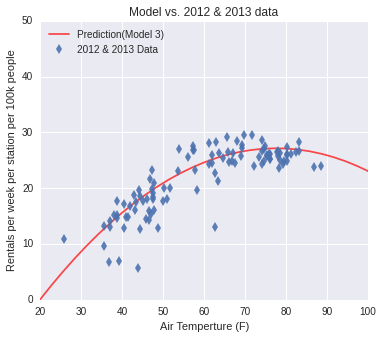

In [50]:
figure = plt.figure(figsize=(20,5))        
x=np.linspace(-20,120)

y=[]
yearDiff=2012-2012
for tempF in x:
    y.append(np.dot(model3['coefficients'],[1,tempF,np.power(tempF,2),yearDiff]))
ax1 = figure.add_subplot(1, 3, 1)
ax1.plot(x,y,'r',alpha=0.7)



#actual data 2013
y=dataForModel3.numRentalsPerWeekPerStationPer100kPeople
x=dataForModel3.airTempF
ax1.plot(x,y,'d',alpha=0.9)

ax1.set_title('Model vs. 2012 & 2013 data')

ax1.legend(['Prediction(Model 3)','2012 & 2013 Data'],loc=2)  

ax1.set_xlim(20,100)

ax1.set_ylim(0,50)
ax2.set_ylim(0,50)

ax1.set_ylabel('Rentals per week per station per 100k people')
ax1.set_xlabel('Air Temperture (F)')

Let's look at the model parameters:

----------
intercept:  -22.1485677093 [-36.65228736808203, -11.902300979370185]

airTempF:  1.2696650122 [0.9024282350937135, 1.7466329779545187]

airTempF_sqrd:  -0.00817421975671 [-0.01195288216532307, -0.005087157265149832]

yearDiff:  -1.82866525104 [-2.9491202375235552, -0.7018897242048978]

sigma^2 2.80818329427 [ 2.10685304  3.39477246]

R^2 0.768903480512 [ 0.66797357  0.85572825]

Again, since the second regressor is just the square of the first one, we are not sure one can interpret beta1 in isolation of the other terms. We will try - again- :

The intercept does not have a meaningful interpretation (-22 Rentals per week per station per 100k people when the temperature is 0 F) does not sound right). 

The predictive interpretation of airTempF is that, ceteris paribus, we should expect the rentals to change 1.26 for every unit change in the temperature. For beta 2, again, we are not 100% sure about its predictive interpretation, but we will try:

We can say that for every unit change of the regressor airTempF_sqrd (squared) away from the vertex we should expect the number of rentals per week per station per 100k people to change by ~0.008,  ceteris paribus. Note here that a unit change does not equate to a 1 degree difference as in the beta1 case. Last, beta2 (yearDiff) shows that for every year that passes, we should expect a reduction of number of rentals per week per station per 100k people  by 1.82. Unfortunately, this does not make much sense, but is the result of our data and normalization procedures.

Let's then build a model that does not use the year difference regressor, and uses data for both 2012 and 2013:

In [51]:
regressors=['airTempF','airTempF_sqrd']

model4=bootstrap_lm("numRentalsPerWeekPerStationPer100kPeople ~ "+"+".join(regressors),dataForModel3)
describe_bootstrap_fit(model4)

regression:  numRentalsPerWeekPerStationPer100kPeople ~ airTempF+airTempF_sqrd
n:  104
----------
intercept:  -24.3104266714 [-37.650795071955756, -13.32499436462004]
airTempF:  1.30894305865 [0.9147609379518068, 1.7842548123166728]
airTempF_sqrd:  -0.0084630203869 [-0.012388083100732469, -0.005224907655192179]
----------
sigma^2 2.94267997244 [ 2.3264464   3.48323892]
R^2 0.743699211299 [ 0.65458207  0.82341305]


The interpretation here is similar to the one above, so we will skip that.
Let's look at the residuals:

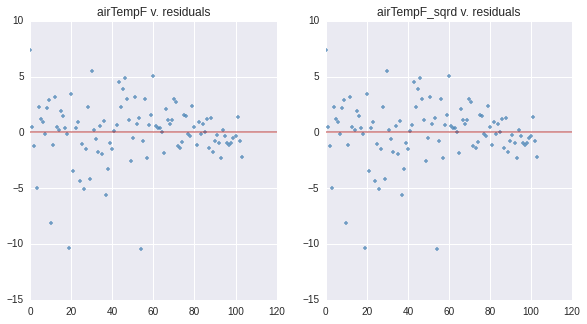

In [52]:
figure = plt.figure(figsize=(15,5))

plots = len( regressors)
rows = (plots // 3) + 1

for i, variable in enumerate( regressors):
    axes = figure.add_subplot(rows, 3, i + 1)
    keyed_values = sorted( zip( dataForModel3[ variable].values, model3[ "residuals"]), key=lambda x: x[ 0])
    residuals = map( lambda x: x[ 1][ 0], keyed_values)

    axes.plot(range(0, model3[ "n"]), residuals, '.', color="steelblue", alpha=0.75)
    axes.axhline(y=0.0, xmin=0, xmax=model3[ "n"], c="firebrick", alpha=0.5)
    axes.set_title( variable + " v. residuals")

Again, the analysis here is very similar to model 2, so we will keep it short. Something important to mention is that we believe the model is in violation of the "equal error variance" assumption. 

Let's plot the data and our model:

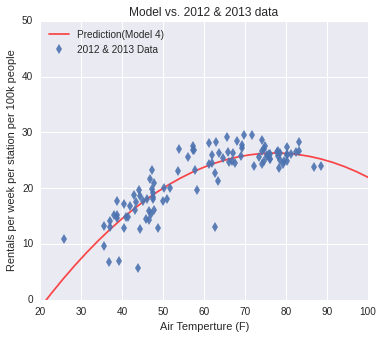

In [53]:
figure = plt.figure(figsize=(20,5))        
x=np.linspace(-20,120)

y=[]
for tempF in x:
    y.append(np.dot(model4['coefficients'],[1,tempF,np.power(tempF,2)]))
ax1 = figure.add_subplot(1, 3, 1)
ax1.plot(x,y,'r',alpha=0.7)



#actual data 2013
y=dataForModel3.numRentalsPerWeekPerStationPer100kPeople
x=dataForModel3.airTempF
ax1.plot(x,y,'d',alpha=0.9)

ax1.set_title('Model vs. 2012 & 2013 data')

ax1.legend(['Prediction(Model 4)','2012 & 2013 Data'],loc=2)  

ax1.set_xlim(20,100)

ax1.set_ylim(0,50)
ax2.set_ylim(0,50)

ax1.set_ylabel('Rentals per week per station per 100k people')
ax1.set_xlabel('Air Temperture (F)')

# To Bike or to not bike? The conclusion:

Model 4 can provide an estimated number of rentals per week per station per 100k people for the Capital Bikeshare system for years 2012 and 2013. 

This model shows that we can use the model to quickly compute the estimated number of rentals. 

If Miami was the city under evaluation, using the average temperature per month we get the following

*weather data at https://en.wikipedia.org/wiki/Climate_of_Miami

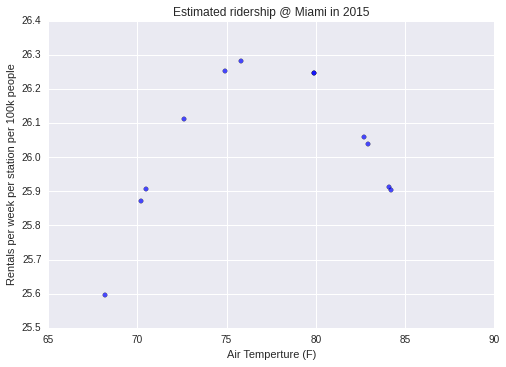

In [54]:
tempF=[68.2,70.2,72.6,75.8,79.9,82.7,84.1,84.2,82.9,79.9,74.9,70.5]
year=2015
  
y=[]
for t in tempF:
    y.append(np.dot(model4['coefficients'],[1,t,np.power(t,2)]))
plt.scatter(tempF,y,alpha=0.7)

plt.ylabel('Rentals per week per station per 100k people')
plt.xlabel('Air Temperture (F)')
plt.title('Estimated ridership @ Miami in 2015')

It can be seen that the number of rentals per week per station per 100k people for Miami at its peak is lower than in DC (too hot?)

Will the business be profitable? It will depend on what threshold (# rentals) puts the company above break-even. 
